## Summary of evaluation methods

| Model         | Band    | Training RMSE | Training Pearson | Testing RMSE | Testing Pearson | Testing CI |
|---------------|---------|---------------|------------------|--------------|-----------------|------------|
| PE            | Beta    | 14.46         | 0.62             | 27.25        | 0.28            | 0.81       |
|               | Delta   | 18.19         | 0.15             | 17.56        | -0.23           |            |
| PE, Mobility  | Beta    | 11.99         | 0.76             | 15.82        | 0.50            |            |
|               | Delta   | 18.17         | 0.16             | 12.42        | 0.28            |            |
| Sample        | Beta    | 11.93         | 0.76             | 28.33        | 0.57            |            |
|               | Delta   | 14.84         | 0.59             | 18.79        | -0.47           |            |
| SE, PE, Mobility | Beta    | 7.47       | 0.91             | 11.78        | 0.78            |            |
|               | Delta   | 14.19         | 0.64             | 23.71        | -0.5            |            |
| FD            | Beta    | 14.95         | 0.58             | 13.32        | 0.43            |            |
|               | Delta   | 17.23         | 0.35             | 19.25        | -0.17           |            |
| SPE           | Beta    | 14.88         | 0.59             | 23.61        | 0.30            |            |
|               | Theta   | 18.19         | 0.15             | 16.85        | 0.06            |            |


In [8]:
import numpy as np
from scipy import stats

# Load Patient 14 data from text file
eeg_data = np.loadtxt('D:\\users\\meyy2\\Documents\\University 2024 - Year 2\\Research Project\\Patient 14 EEG.txt')

from scipy.signal import butter, filtfilt

# Define band filter
def band_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Sampling frequency = 128 Hz
fs = 128

# Apply filters for each band
delta_band = band_filter(eeg_data, 0.5, 4, fs) # 0.5 to 4 Hz
theta_band = band_filter(eeg_data, 4, 8, fs) # 4 to 8 Hz
alpha_band = band_filter(eeg_data, 8, 13, fs) # 8 to 13 Hz
beta_band = band_filter(eeg_data, 13, 30, fs) # 13 to 30 Hz
gamma_band = band_filter(eeg_data, 30, 63, fs) # 30 to 63 Hz (within Nyquist range)

# Create overlapping 56 s windows of different bands, advancing by 1 s
def moving_window(data, window_size, step_size, fs):
    num_points = len(data)
    window_length = window_size * fs # Length of window in data points
    step_length = step_size * fs # Length of step in data points
    windows = []
    for start in range(0, num_points - window_length + 1, step_length):
        windows.append(data[start:start + window_length])
    return np.array(windows)

window_size = 56 # Length of window in seconds
step_size = 1 # Length of step in seconds
alpha_windows = moving_window(alpha_band, window_size, step_size, fs)
beta_windows = moving_window(beta_band, window_size, step_size, fs)
delta_windows = moving_window(delta_band, window_size, step_size, fs)
theta_windows = moving_window(theta_band, window_size, step_size, fs)
gamma_windows = moving_window(gamma_band, window_size, step_size, fs)

(3001,)
FD Index Equation: BIS = -77.070469341763 * FE1 + 154.0104473002731


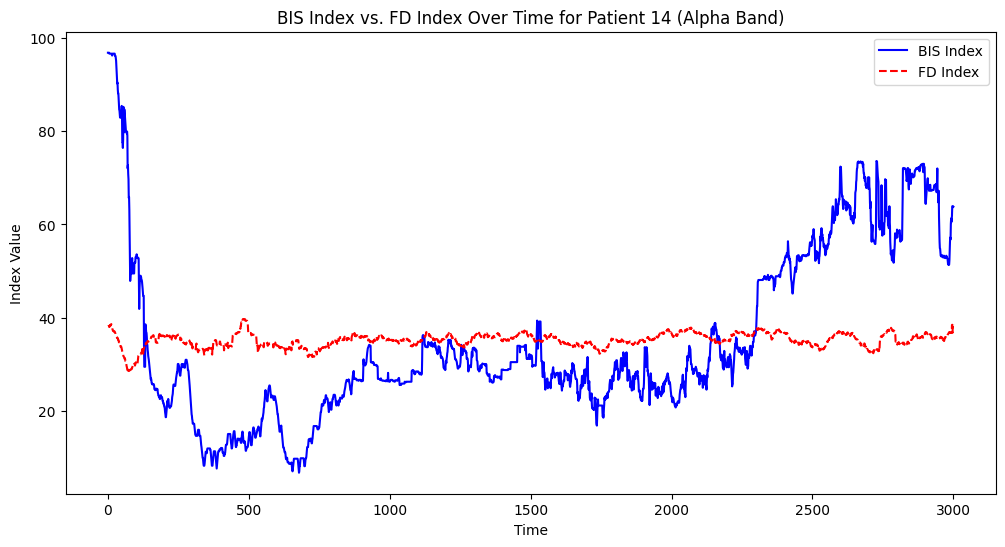

RMSE:  18.33973665353874


In [9]:
import antropy as ant

fd_values_alpha = []

for i, window in enumerate(alpha_windows):
    fd = ant.higuchi_fd(window)
    fd_values_alpha.append(fd)

fd_values_alpha = np.array(fd_values_alpha)
print(fd_values_alpha.shape)

import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load BIS data of Patient 14
patient14_bis = np.loadtxt('D:\\users\\meyy2\\Documents\\University 2024 - Year 2\\Research Project\\Patient 14 BIS.txt')

fd_df_alpha = pd.DataFrame(fd_values_alpha, columns=['FD']) # Convert FD numpy array to pandas DataFrame

# Align BIS and PE values by disregarding the first 55 BIS values, as each PE value will represent the end of the window
bis_aligned = patient14_bis[55:55+len(fd_df_alpha)]

# Prepare data
bis_series = pd.Series(bis_aligned, name='BIS')

# Create the FD index (alpha)
FD1_alpha = fd_df_alpha.values.reshape(-1, 1)
FD_model_alpha = LinearRegression()
FD_model_alpha.fit(FD1_alpha, bis_series)
FD_index_alpha = FD_model_alpha.predict(FD1_alpha)

# Calculate the regression coefficients
k_FD_alpha = FD_model_alpha.coef_[0]
b_FD_alpha= FD_model_alpha.intercept_
print(f"FD Index Equation: BIS = {k_FD_alpha} * FE1 + {b_FD_alpha}")

# Plot BIS Index vs. FD Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(FD_index_alpha, label='FD Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. FD Index Over Time for Patient 14 (Alpha Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the combined model
rmse_fd_alpha = np.sqrt(mean_squared_error(bis_series, FD_index_alpha))
print("RMSE: ", rmse_fd_alpha)

(3001,)
FD Index Equation: BIS = 959.4142652100251 * FD + -1855.1058617249985


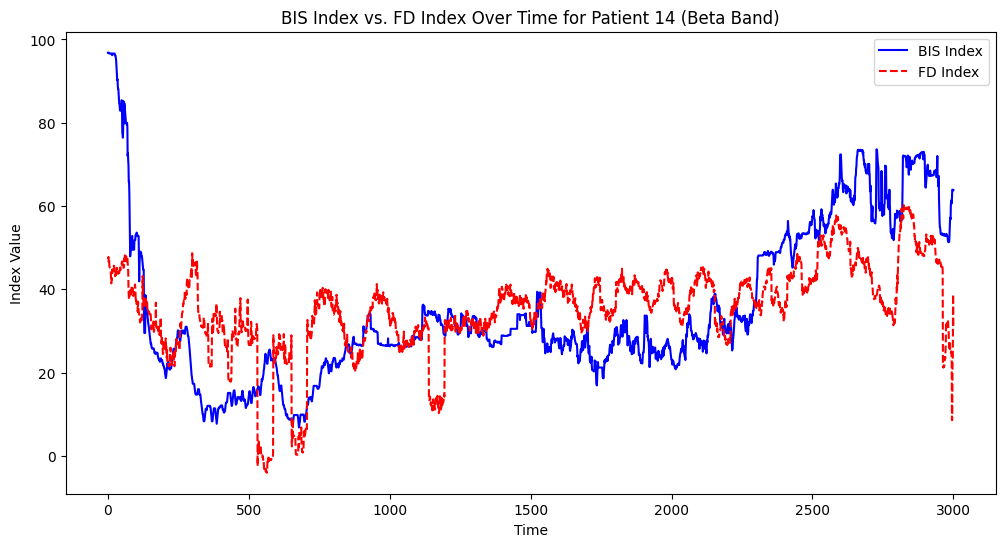

RMSE:  14.951895199462513


In [10]:
fd_values_beta = []

for i, window in enumerate(beta_windows):
    fd = ant.higuchi_fd(window)
    fd_values_beta.append(fd)

fd_values_beta = np.array(fd_values_beta)
print(fd_values_beta.shape)

fd_df_beta = pd.DataFrame(fd_values_beta, columns=['FD']) # Convert FD numpy array to pandas DataFrame

# Create the FD index (beta)
FD1_beta = fd_df_beta.values.reshape(-1, 1)
FD_model_beta = LinearRegression()
FD_model_beta.fit(FD1_beta, bis_series)
FD_index_beta = FD_model_beta.predict(FD1_beta)

# Calculate the regression coefficients
k_FD_beta = FD_model_beta.coef_[0]
b_FD_beta= FD_model_beta.intercept_
print(f"FD Index Equation: BIS = {k_FD_beta} * FD + {b_FD_beta}")

# Plot BIS Index vs. FD Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(FD_index_beta, label='FD Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. FD Index Over Time for Patient 14 (Beta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE)
rmse_fd_beta = np.sqrt(mean_squared_error(bis_series, FD_index_beta))
print("RMSE: ", rmse_fd_beta)

(3001,)
FD Index Equation: BIS = -2176.3832290488162 * FD + 2261.3060812358895


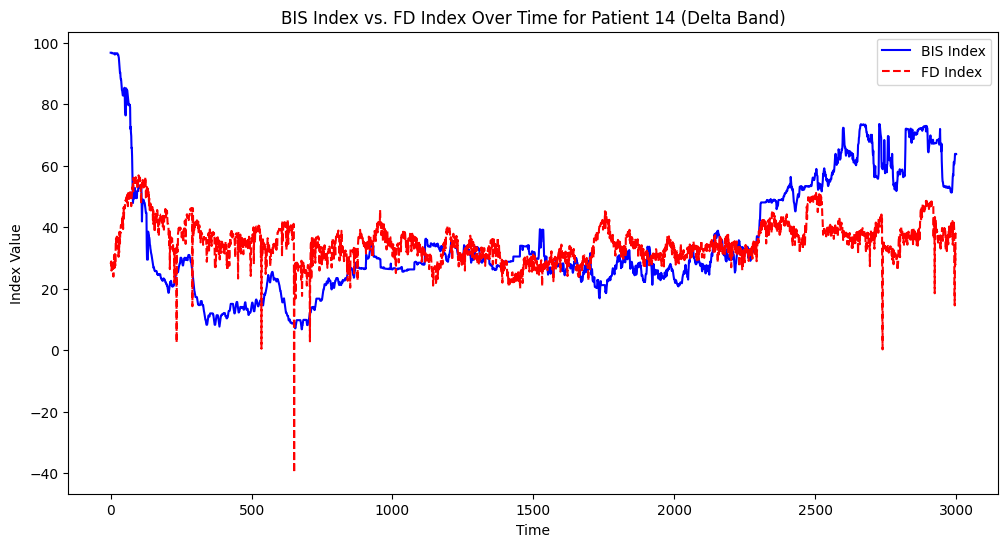

RMSE:  17.229542064797027
FD Delta Training Model Pearson CC:  0.3510437211736839


In [11]:
fd_values_delta = []

for i, window in enumerate(delta_windows):
    fd = ant.higuchi_fd(window)
    fd_values_delta.append(fd)

fd_values_delta = np.array(fd_values_delta)
print(fd_values_delta.shape)

fd_df_delta = pd.DataFrame(fd_values_delta, columns=['FD']) # Convert FD numpy array to pandas DataFrame

# Create the FD index (delta)
FD1_delta = fd_df_delta.values.reshape(-1, 1)
FD_model_delta = LinearRegression()
FD_model_delta.fit(FD1_delta, bis_series)
FD_index_delta = FD_model_delta.predict(FD1_delta)

# Calculate the regression coefficients
k_FD_delta = FD_model_delta.coef_[0]
b_FD_delta = FD_model_delta.intercept_
print(f"FD Index Equation: BIS = {k_FD_delta} * FD + {b_FD_delta}")

# Plot BIS Index vs. FD Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(FD_index_delta, label='FD Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. FD Index Over Time for Patient 14 (Delta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE)
rmse_fd_delta = np.sqrt(mean_squared_error(bis_series, FD_index_delta))
print("RMSE: ", rmse_fd_delta)

# Calculate Pearson correlation coefficient
correlation_fd_delta, _ = stats.pearsonr(FD_index_delta, bis_series)
print("FD Delta Training Model Pearson CC: ", correlation_fd_delta)

(3001,)
FD Index Equation: BIS = -335.260645935475 * FD + 422.34436823965933


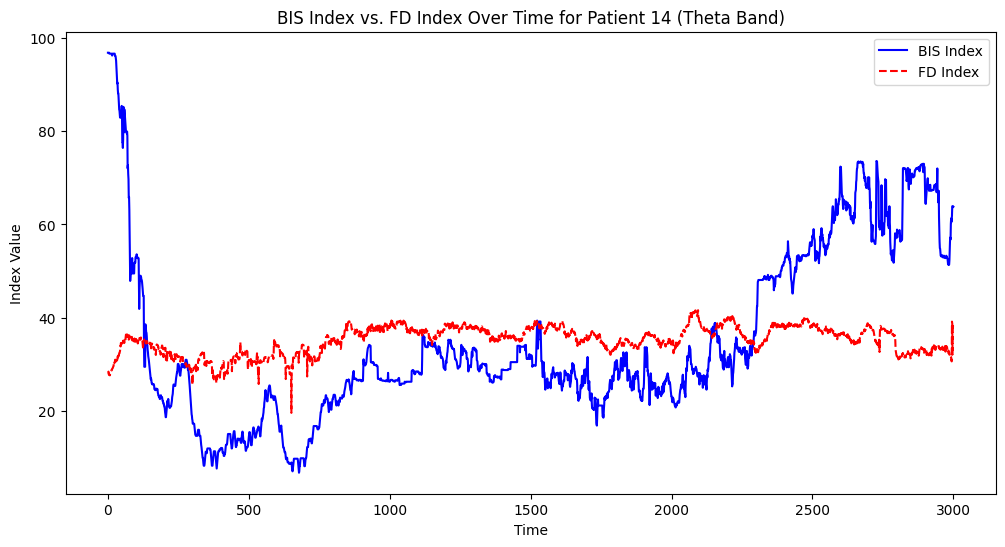

RMSE:  18.164234793234716


In [12]:
fd_values_theta = []

for i, window in enumerate(theta_windows):
    fd = ant.higuchi_fd(window)
    fd_values_theta.append(fd)

fd_values_theta = np.array(fd_values_theta)
print(fd_values_theta.shape)

fd_df_theta = pd.DataFrame(fd_values_theta, columns=['FD']) # Convert FD numpy array to pandas DataFrame

# Create the FD index (theta)
FD1_theta = fd_df_theta.values.reshape(-1, 1)
FD_model_theta = LinearRegression()
FD_model_theta.fit(FD1_theta, bis_series)
FD_index_theta = FD_model_theta.predict(FD1_theta)

# Calculate the regression coefficients
k_FD_theta = FD_model_theta.coef_[0]
b_FD_theta = FD_model_theta.intercept_
print(f"FD Index Equation: BIS = {k_FD_theta} * FD + {b_FD_theta}")

# Plot BIS Index vs. FD Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(FD_index_theta, label='FD Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. FD Index Over Time for Patient 14 (Theta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE)
rmse_fd_theta = np.sqrt(mean_squared_error(bis_series, FD_index_theta))
print("RMSE: ", rmse_fd_theta)

(3001,)
FD Index Equation: BIS = -321.2650976546967 * FD + 691.5091093670259


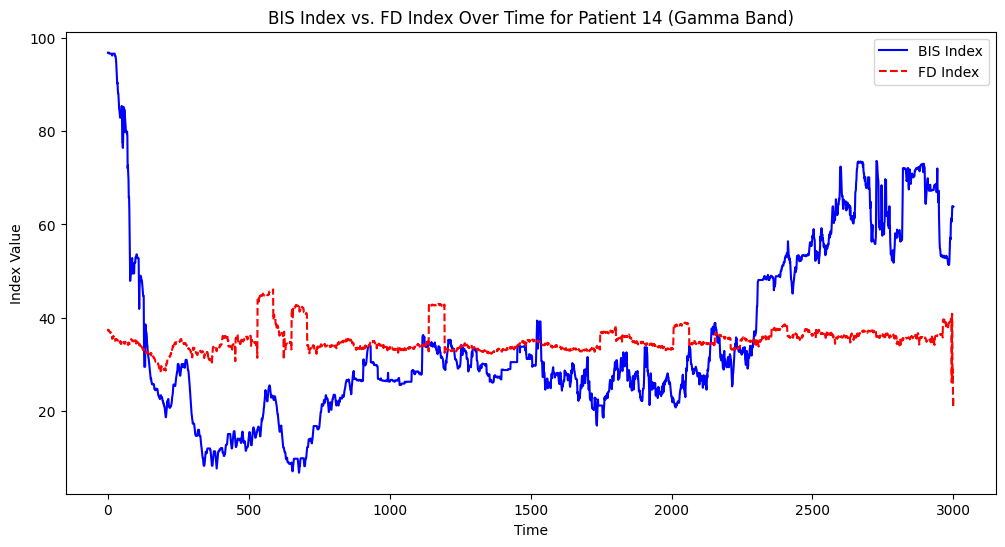

RMSE:  18.215787016832035


In [13]:
fd_values_gamma = []

for i, window in enumerate(gamma_windows):
    fd = ant.higuchi_fd(window)
    fd_values_gamma.append(fd)

fd_values_gamma = np.array(fd_values_gamma)
print(fd_values_gamma.shape)

fd_df_gamma = pd.DataFrame(fd_values_gamma, columns=['FD']) # Convert FD numpy array to pandas DataFrame

# Create the FD index (gamma)
FD1_gamma = fd_df_gamma.values.reshape(-1, 1)
FD_model_gamma = LinearRegression()
FD_model_gamma.fit(FD1_gamma, bis_series)
FD_index_gamma = FD_model_gamma.predict(FD1_gamma)

# Calculate the regression coefficients
k_FD_gamma = FD_model_gamma.coef_[0]
b_FD_gamma = FD_model_gamma.intercept_
print(f"FD Index Equation: BIS = {k_FD_gamma} * FD + {b_FD_gamma}")

# Plot BIS Index vs. FD Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(FD_index_gamma, label='FD Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. FD Index Over Time for Patient 14 (Gamma Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE)
rmse_fd_gamma = np.sqrt(mean_squared_error(bis_series, FD_index_gamma))
print("RMSE: ", rmse_fd_gamma)

(3001,)
ZC Index Equation: BIS = 0.09216302740736312 * ZC + -159.09879929063615


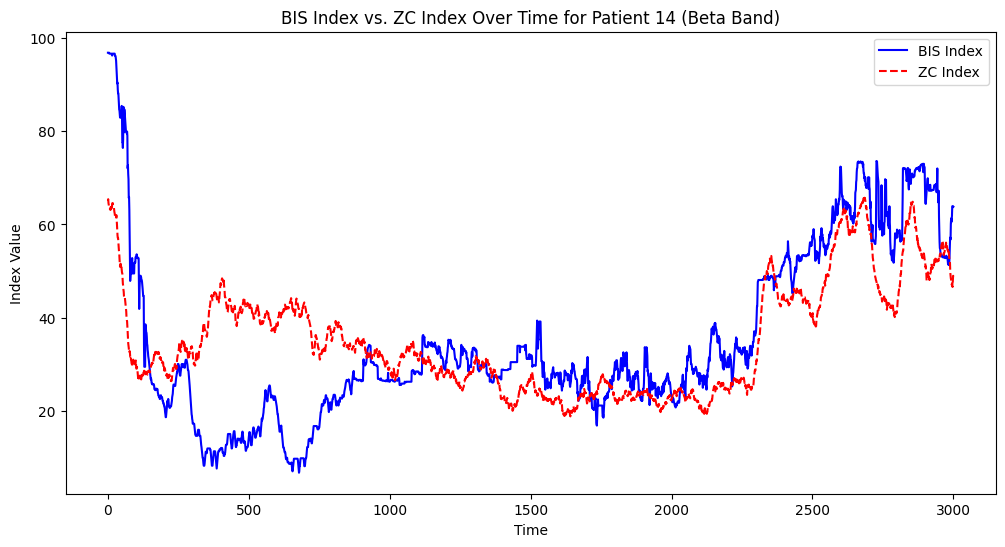

RMSE:  14.19514667460146


In [14]:
zc_values_beta = []

for i, window in enumerate(beta_windows):
    zc = ant.num_zerocross(window)
    zc_values_beta.append(zc)

zc_values_beta = np.array(zc_values_beta)
print(zc_values_beta.shape)

zc_df_beta = pd.DataFrame(zc_values_beta, columns=['ZC']) # Convert ZC numpy array to pandas DataFrame

# Create the ZC index (beta)
ZC1_beta = zc_df_beta.values.reshape(-1, 1)
ZC_model_beta = LinearRegression()
ZC_model_beta.fit(ZC1_beta, bis_series)
ZC_index_beta = ZC_model_beta.predict(ZC1_beta)

# Calculate the regression coefficients
k_ZC_beta = ZC_model_beta.coef_[0]
b_ZC_beta= ZC_model_beta.intercept_
print(f"ZC Index Equation: BIS = {k_ZC_beta} * ZC + {b_ZC_beta}")

# Plot BIS Index vs. ZC Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(ZC_index_beta, label='ZC Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. ZC Index Over Time for Patient 14 (Beta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE)
rmse_zc_beta = np.sqrt(mean_squared_error(bis_series, ZC_index_beta))
print("RMSE: ", rmse_zc_beta)


(3001,)
ZC Index Equation: BIS = 0.49805449319681927 * ZC + -31.692070238276038


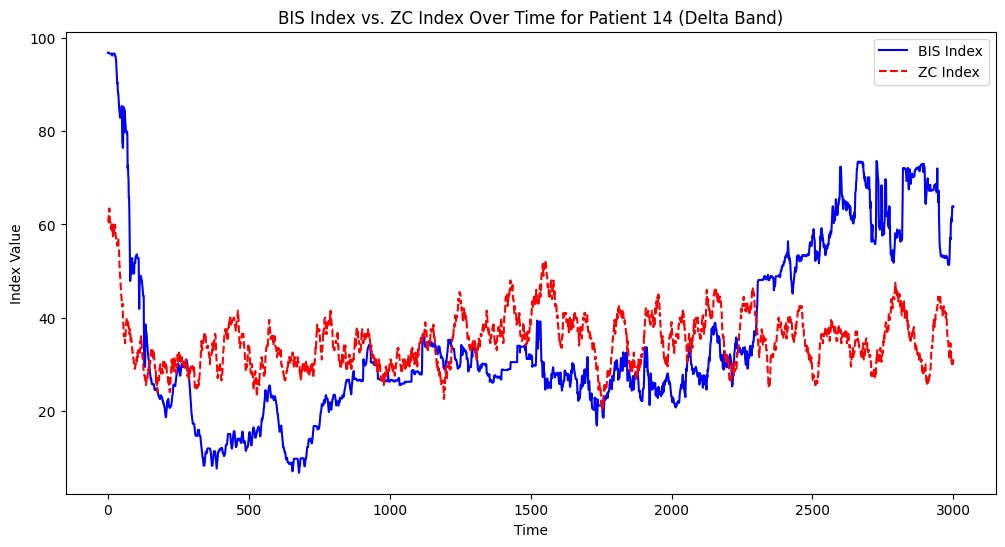

RMSE:  17.38782247018217


In [15]:
zc_values_delta = []

for i, window in enumerate(delta_windows):
    zc = ant.num_zerocross(window)
    zc_values_delta.append(zc)

zc_values_delta = np.array(zc_values_delta)
print(zc_values_delta.shape)

zc_df_delta = pd.DataFrame(zc_values_delta, columns=['ZC']) # Convert ZC numpy array to pandas DataFrame

# Create the ZC index (delta)
ZC1_delta = zc_df_delta.values.reshape(-1, 1)
ZC_model_delta = LinearRegression()
ZC_model_delta.fit(ZC1_delta, bis_series)
ZC_index_delta = ZC_model_delta.predict(ZC1_delta)

# Calculate the regression coefficients
k_ZC_delta = ZC_model_delta.coef_[0]
b_ZC_delta = ZC_model_delta.intercept_
print(f"ZC Index Equation: BIS = {k_ZC_delta} * ZC + {b_ZC_delta}")

# Plot BIS Index vs. ZC Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(ZC_index_delta, label='ZC Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. ZC Index Over Time for Patient 14 (Delta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE)
rmse_zc_delta = np.sqrt(mean_squared_error(bis_series, ZC_index_delta))
print("RMSE: ", rmse_zc_delta)


(3001,)
ZC Index Equation: BIS = 0.019330766784309058 * ZC + 13.092744102184145


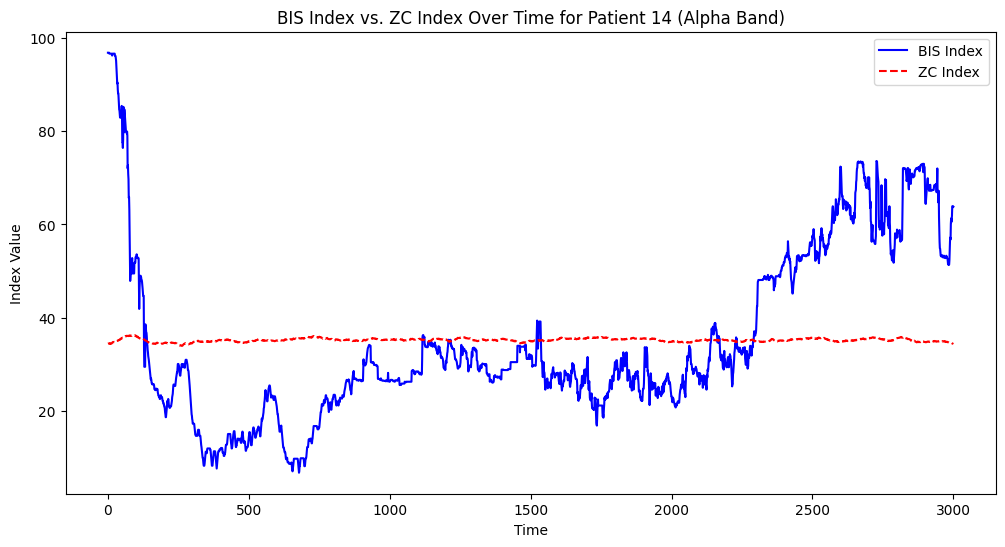

RMSE:  18.39705407168736


In [16]:
zc_values_alpha = []

for i, window in enumerate(alpha_windows):
    zc = ant.num_zerocross(window)
    zc_values_alpha.append(zc)

zc_values_alpha = np.array(zc_values_alpha)
print(zc_values_alpha.shape)

zc_df_alpha = pd.DataFrame(zc_values_alpha, columns=['ZC']) # Convert ZC numpy array to pandas DataFrame

# Create the ZC index (alpha)
ZC1_alpha = zc_df_alpha.values.reshape(-1, 1)
ZC_model_alpha = LinearRegression()
ZC_model_alpha.fit(ZC1_alpha, bis_series)
ZC_index_alpha = ZC_model_alpha.predict(ZC1_alpha)

# Calculate the regression coefficients
k_ZC_alpha = ZC_model_alpha.coef_[0]
b_ZC_alpha = ZC_model_alpha.intercept_
print(f"ZC Index Equation: BIS = {k_ZC_alpha} * ZC + {b_ZC_alpha}")

# Plot BIS Index vs. ZC Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(ZC_index_alpha, label='ZC Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. ZC Index Over Time for Patient 14 (Alpha Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE)
rmse_zc_alpha = np.sqrt(mean_squared_error(bis_series, ZC_index_alpha))
print("RMSE: ", rmse_zc_alpha)


(3001,)
ZC Index Equation: BIS = 0.061629408709947445 * ZC + -4.0763835981335035


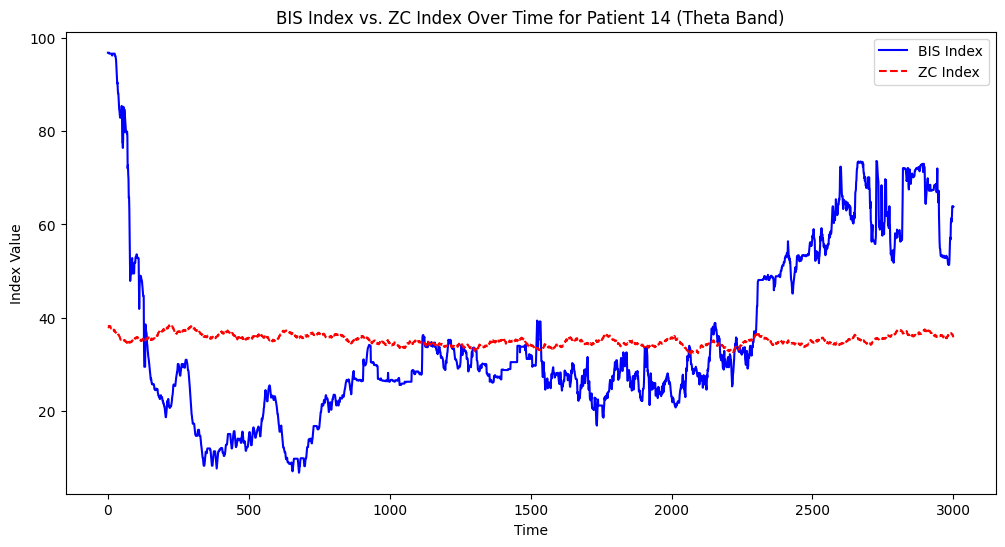

RMSE:  18.365357963633272


In [17]:
zc_values_theta = []

for i, window in enumerate(theta_windows):
    zc = ant.num_zerocross(window)
    zc_values_theta.append(zc)

zc_values_theta = np.array(zc_values_theta)
print(zc_values_theta.shape)

zc_df_theta = pd.DataFrame(zc_values_theta, columns=['ZC']) # Convert ZC numpy array to pandas DataFrame

# Create the ZC index (alpha)
ZC1_theta = zc_df_theta.values.reshape(-1, 1)
ZC_model_theta = LinearRegression()
ZC_model_theta.fit(ZC1_theta, bis_series)
ZC_index_theta = ZC_model_theta.predict(ZC1_theta)

# Calculate the regression coefficients
k_ZC_theta = ZC_model_theta.coef_[0]
b_ZC_theta = ZC_model_theta.intercept_
print(f"ZC Index Equation: BIS = {k_ZC_theta} * ZC + {b_ZC_theta}")

# Plot BIS Index vs. ZC Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(ZC_index_theta, label='ZC Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. ZC Index Over Time for Patient 14 (Theta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE)
rmse_zc_theta = np.sqrt(mean_squared_error(bis_series, ZC_index_theta))
print("RMSE: ", rmse_zc_theta)


(3001,)
ZC Index Equation: BIS = 0.05990834758644792 * ZC + -227.0301633850269


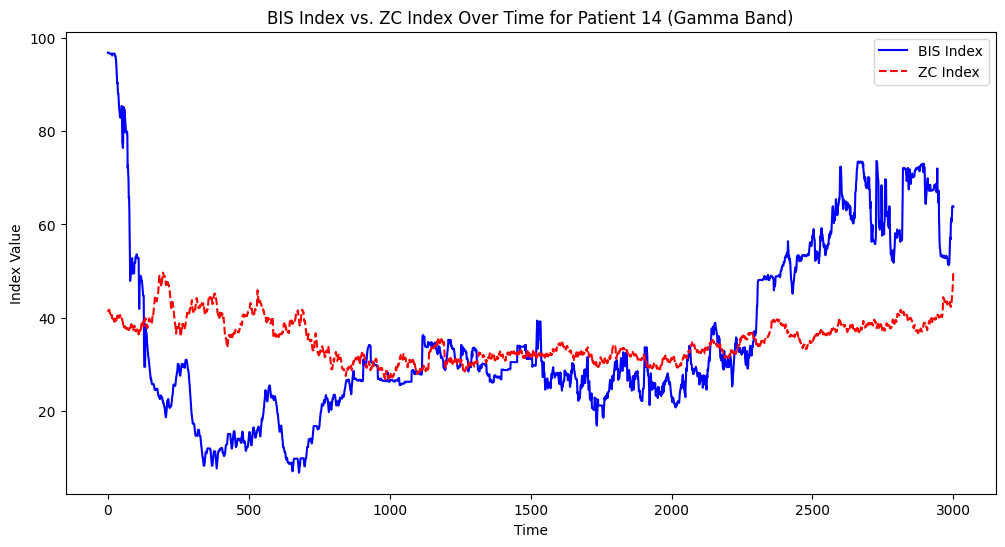

RMSE:  17.860615988710524


In [18]:
zc_values_gamma = []

for i, window in enumerate(gamma_windows):
    zc = ant.num_zerocross(window)
    zc_values_gamma.append(zc)

zc_values_gamma = np.array(zc_values_gamma)
print(zc_values_gamma.shape)

zc_df_gamma = pd.DataFrame(zc_values_gamma, columns=['ZC']) # Convert ZC numpy array to pandas DataFrame

# Create the ZC index (alpha)
ZC1_gamma = zc_df_gamma.values.reshape(-1, 1)
ZC_model_gamma = LinearRegression()
ZC_model_gamma.fit(ZC1_gamma, bis_series)
ZC_index_gamma = ZC_model_gamma.predict(ZC1_gamma)

# Calculate the regression coefficients
k_ZC_gamma = ZC_model_gamma.coef_[0]
b_ZC_gamma = ZC_model_gamma.intercept_
print(f"ZC Index Equation: BIS = {k_ZC_gamma} * ZC + {b_ZC_gamma}")

# Plot BIS Index vs. ZC Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(ZC_index_gamma, label='ZC Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. ZC Index Over Time for Patient 14 (Gamma Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE)
rmse_zc_gamma = np.sqrt(mean_squared_error(bis_series, ZC_index_gamma))
print("RMSE: ", rmse_zc_gamma)


Combined Index Equation: BIS = 8.41 * FD + 9.70 * ZC + 35.22


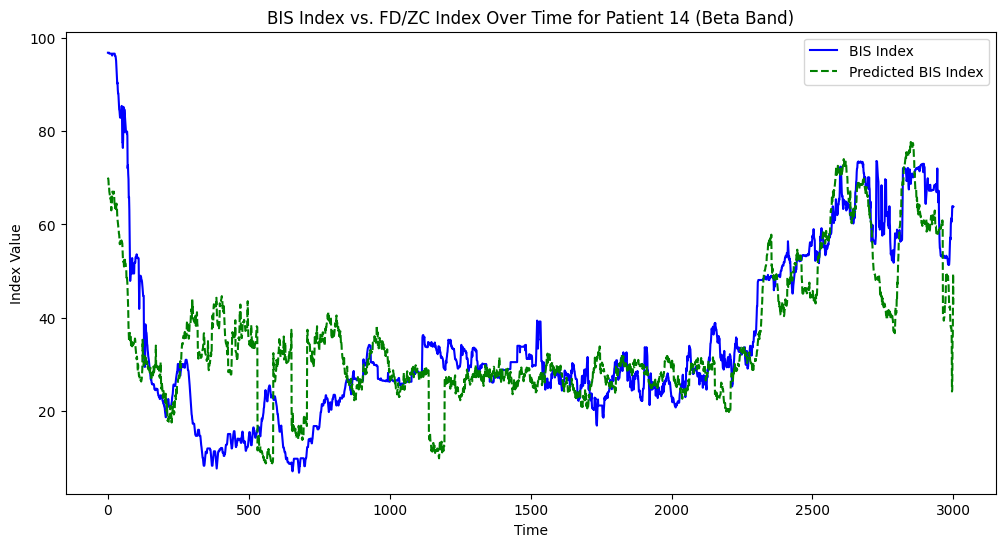

Combined Model RMSE:  11.613604667323257


In [19]:
from sklearn.preprocessing import StandardScaler

# Normalise features
features = np.column_stack((fd_values_beta, zc_values_beta))
scaler = StandardScaler()
normalised_features = scaler.fit_transform(features)

FD_index_norm = normalised_features[:, 0]
ZC_index_norm = normalised_features[:, 1]

X_combined_beta = np.column_stack((FD_index_norm, ZC_index_norm))
y_combined_beta = bis_series 

# Initialize and fit the linear regression model
combined_model_beta = LinearRegression()
combined_model_beta.fit(X_combined_beta, y_combined_beta)

# Predict the BIS index using the learned model
predicted_bis_beta = combined_model_beta.predict(X_combined_beta)

# Get the regression coefficients and intercept
coefficients_beta = combined_model_beta.coef_
intercept_beta = combined_model_beta.intercept_

# Output the combined index equation
print(f"Combined Index Equation: BIS = {coefficients_beta[0]:.2f} * FD + {coefficients_beta[1]:.2f} * ZC + {intercept_beta:.2f}")

# Plot BIS Index vs. Predicted Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(predicted_bis_beta, label='Predicted BIS Index', color='green', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. FD/ZC Index Over Time for Patient 14 (Beta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the combined model
rmse_combined_beta = np.sqrt(mean_squared_error(bis_series, predicted_bis_beta))
print("Combined Model RMSE: ", rmse_combined_beta)

Combined Index Equation: BIS = 8.41 * FD + 9.70 * ZC + 35.22


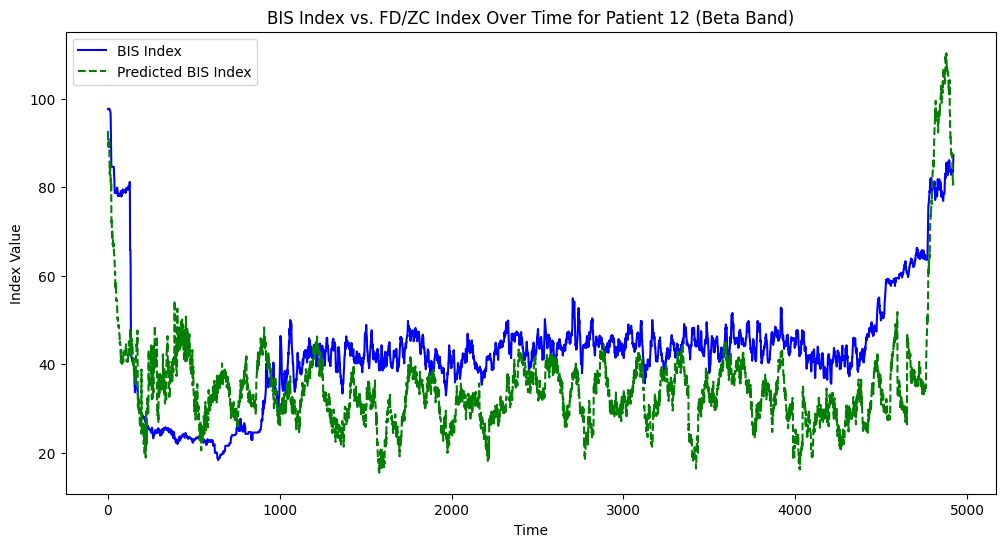

Combined Model RMSE:  14.39305038648548


In [20]:
# Load Patient 12 data
eeg_data_patient12 = np.loadtxt('D:\\users\\meyy2\\Documents\\University 2024 - Year 2\\Research Project\\Patient 12 EEG data.txt')
bis_patient12 = np.loadtxt('D:\\users\\meyy2\\Documents\\University 2024 - Year 2\\Research Project\\Patient 12 BIS.txt')

# Apply filters for each band for Patient 12
delta_band_patient12 = band_filter(eeg_data_patient12, 0.5, 4, fs) # 0.5 to 4 Hz
theta_band_patient12 = band_filter(eeg_data_patient12, 4, 8, fs) # 4 to 8 Hz
alpha_band_patient12 = band_filter(eeg_data_patient12, 8, 13, fs) # 8 to 13 Hz
beta_band_patient12 = band_filter(eeg_data_patient12, 13, 30, fs) # 13 to 30 Hz
gamma_band_patient12 = band_filter(eeg_data_patient12, 30, 63, fs) # 30 to 63 Hz (within Nyquist range

# Patient 12 moving windows
alpha_windows_patient12 = moving_window(alpha_band_patient12, window_size, step_size, fs)
beta_windows_patient12 = moving_window(beta_band_patient12, window_size, step_size, fs)
delta_windows_patient12 = moving_window(delta_band_patient12, window_size, step_size, fs)
theta_windows_patient12 = moving_window(theta_band_patient12, window_size, step_size, fs)
gamma_windows_patient12 = moving_window(gamma_band_patient12, window_size, step_size, fs)

# Calculate FD for Patient 12
fd_values_beta_patient12 = []

for i, window in enumerate(beta_windows_patient12):
    fd = ant.higuchi_fd(window)
    fd_values_beta_patient12.append(fd)

fd_values_beta_patient12 = np.array(fd_values_beta_patient12)

# Calculate number of zero crossings (ZC) for Patient 12
zc_values_beta_patient12 = []

for i, window in enumerate(beta_windows_patient12):
    zc = ant.num_zerocross(window)
    zc_values_beta_patient12.append(zc)

zc_values_beta_patient12 = np.array(zc_values_beta_patient12)

##########

bis_aligned_patient12 = bis_patient12[55:55+len(beta_windows_patient12)]

# Normalise mobility and PE for Patient 12
features_beta_patient12 = np.column_stack((fd_values_beta_patient12, zc_values_beta_patient12))
normalised_features_patient12 = scaler.fit_transform(features_beta_patient12)

FD_index_norm_patient12 = normalised_features_patient12[:, 0]
ZC_index_norm_patient12 = normalised_features_patient12[:, 1]

X_combined_patient12 = np.column_stack((FD_index_norm_patient12, ZC_index_norm_patient12))
y_combined_patient12 = bis_aligned_patient12

# Output the combined index equation
print(f"Combined Index Equation: BIS = {coefficients_beta[0]:.2f} * FD + {coefficients_beta[1]:.2f} * ZC + {intercept_beta:.2f}")

# Predict the BIS index using the learned model
predicted_bis_patient12 = combined_model_beta.predict(X_combined_patient12)

# Plot BIS Index vs. Predicted Index
plt.figure(figsize=(12, 6))
plt.plot(bis_aligned_patient12, label='BIS Index', color='blue')
plt.plot(predicted_bis_patient12, label='Predicted BIS Index', color='green', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. FD/ZC Index Over Time for Patient 12 (Beta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the combined model
rmse_combined_patient12 = np.sqrt(mean_squared_error(bis_aligned_patient12, predicted_bis_patient12))
print("Combined Model RMSE: ", rmse_combined_patient12)

(4921,)


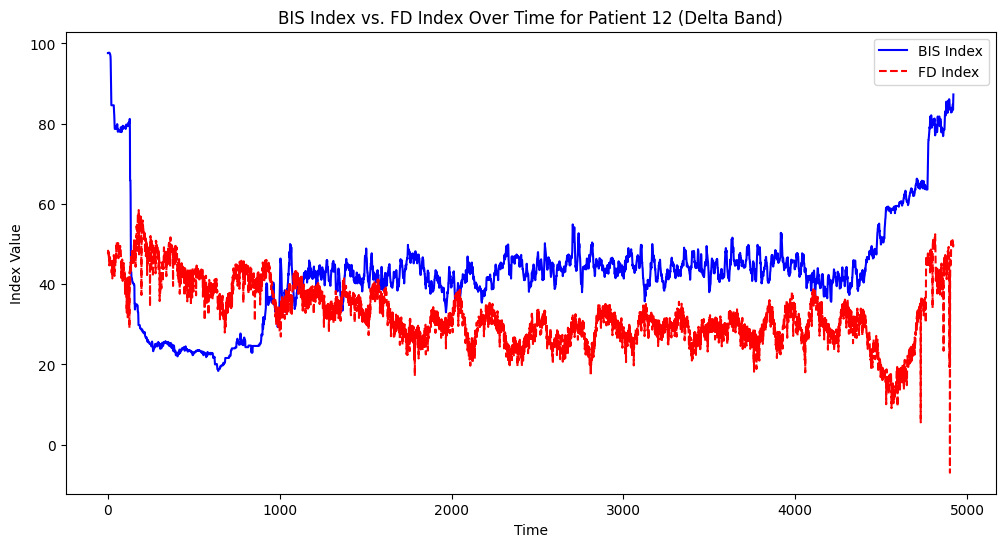

RMSE:  19.254845618881973
SE Beta Training Model Pearson CC:  -0.1651672646190978


In [21]:
fd_values_delta_patient12 = []

for i, window in enumerate(delta_windows_patient12):
    fd = ant.higuchi_fd(window)
    fd_values_delta_patient12.append(fd)

fd_values_delta_patient12 = np.array(fd_values_delta_patient12)
print(fd_values_delta_patient12.shape)

# Create the FD index for testing
fd_delta_df_patient12 = pd.DataFrame(fd_values_delta_patient12, columns=['FD2']) # Convert SE numpy array to pandas DataFrame
FD_delta_patient12 = fd_delta_df_patient12.values.reshape(-1, 1)
FD_index_delta_patient12 = FD_model_delta.predict(FD_delta_patient12)

# Plot BIS Index vs. FD Index
plt.figure(figsize=(12, 6))
plt.plot(bis_aligned_patient12, label='BIS Index', color='blue')
plt.plot(FD_index_delta_patient12, label='FD Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. FD Index Over Time for Patient 12 (Delta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE)
actual_FD2 = np.array([bis_aligned_patient12])
predicted_FD2 = np.array([FD_index_delta_patient12])

mse_FD2 = mean_squared_error(actual_FD2, predicted_FD2)

rmse_FD2 = np.sqrt(mse_FD2)

print("RMSE: ", rmse_FD2)

# Calculate Pearson correlation coefficient
correlation_fd_delta_patient12, _ = stats.pearsonr(FD_index_delta_patient12, bis_aligned_patient12)
print("SE Beta Training Model Pearson CC: ", correlation_fd_delta_patient12)

### Patient 14 RMSE across all frequency bands
|      | FD    | ZC    | Combined |
|------|-------|-------|----------|
| Beta | 14.95 | 14.20 | 11.61    |
| Alpha| 18.34 | 18.40 |          |
| Delta| 17.23 | 17.39 |          |
| Theta| 18.16 | 18.37 |          |
| Gamma| 18.22 | 17.86 |          |

**Testing Combined (Patient 12)**: 14.39


### Summary of model results (beta band only)
| Model            | Training RMSE (Patient 14) | Testing RMSE (Patient 12) |
| :--------------- | :------------------------- | :------------------------ |
| PE               | 14.46                      | 27.25                     |
| Mobility         | 12.02                      | 21.78                     |
| PE and Mobility  | 11.99                      | 15.82                     |
| Sample entropy (SE)| 11.93                    | 10.93                     |
| SE, PE, Mobility | 7.47                       | 11.78                     |               
| Fractal dimension| 14.95                      | 13.32                     |        
| Spectral entropy (SPE) | 14.88                | 23.61                     |       

PE Index Equation: BIS = 241.1348601773862 * PE1 + -401.83825735978513


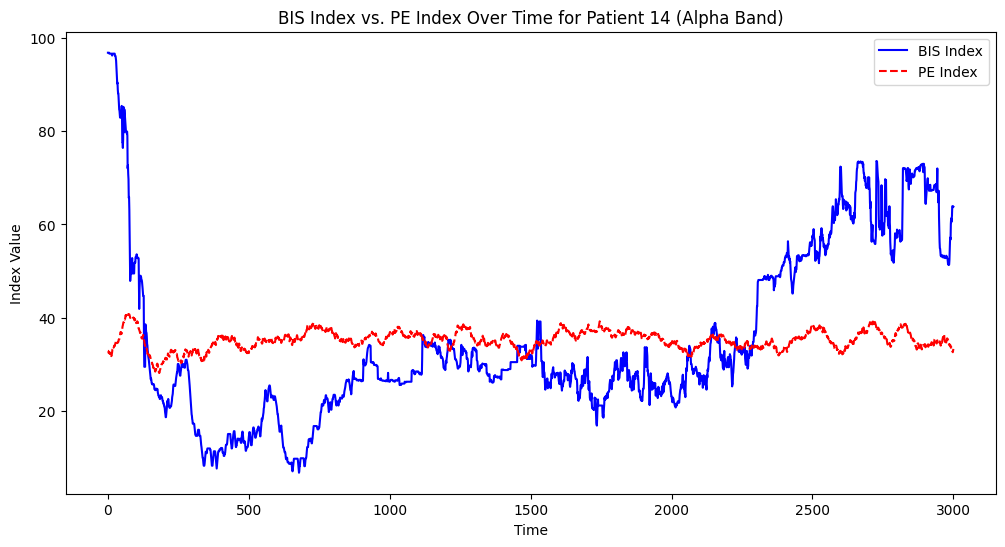

Combined Model RMSE:  18.29502197350327


In [22]:
from pyentrp import entropy as ent

pe_values_alpha = []
for window in alpha_windows:
    pe = ent.permutation_entropy(window, order=3, delay=1)
    pe_values_alpha.append(pe)

pe_values_alpha = np.array(pe_values_alpha)

pe_values_delta = []
for window in delta_windows:
    pe = ent.permutation_entropy(window, order=3, delay=1)
    pe_values_delta.append(pe)

pe_values_delta = np.array(pe_values_delta)

pe_values_theta = []
for window in theta_windows:
    pe = ent.permutation_entropy(window, order=3, delay=1)
    pe_values_theta.append(pe)

pe_values_theta = np.array(pe_values_theta)

pe_values_gamma = []
for window in gamma_windows:
    pe = ent.permutation_entropy(window, order=3, delay=1)
    pe_values_gamma.append(pe)

pe_values_gamma = np.array(pe_values_gamma)

# Create the PE index for alpha band
pe_df_alpha = pd.DataFrame(pe_values_alpha, columns=['PE']) # Convert PE numpy array to pandas DataFrame
PE_alpha = pe_df_alpha.values.reshape(-1, 1)
PE_model_alpha = LinearRegression()
PE_model_alpha.fit(PE_alpha, bis_series)
PE_index_alpha = PE_model_alpha.predict(PE_alpha)

# Calculate the regression coefficients
k_PE_alpha = PE_model_alpha.coef_[0]
b_PE_alpha = PE_model_alpha.intercept_
print(f"PE Index Equation: BIS = {k_PE_alpha} * PE1 + {b_PE_alpha}")

# Plot BIS Index vs. PE Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(PE_index_alpha, label='PE Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. PE Index Over Time for Patient 14 (Alpha Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the combined model
rmse_pe_alpha = np.sqrt(mean_squared_error(bis_series, PE_index_alpha))
print("Combined Model RMSE: ", rmse_pe_alpha)

PE Index Equation: BIS = -221.59126228671425 * PE1 + 314.43656223450574


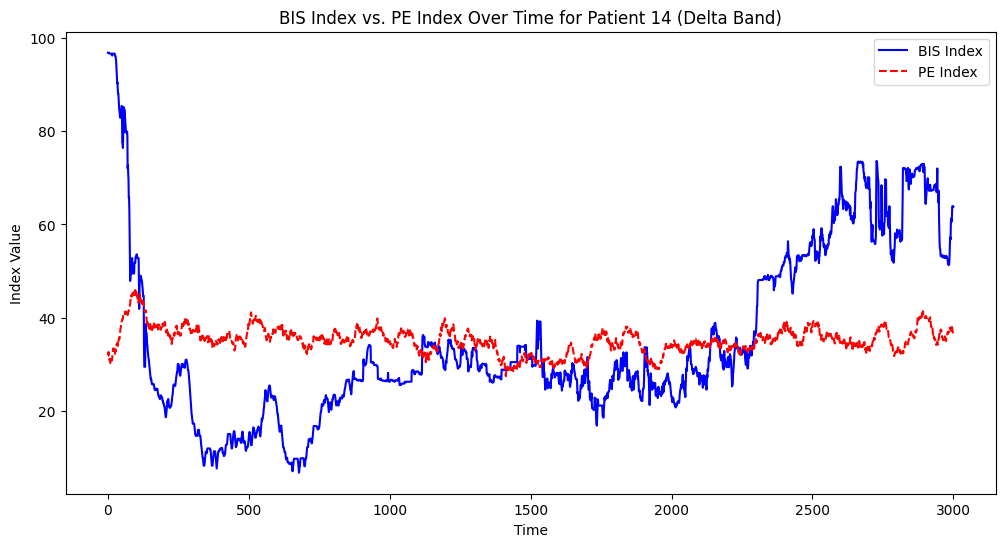

PE Delta Training Model RMSE:  18.185944310565343
PE Delta Training Model Pearson CC:  0.15229009469643354


In [23]:
# Create the PE index for delta band
pe_df_delta = pd.DataFrame(pe_values_delta, columns=['PE']) # Convert PE numpy array to pandas DataFrame
PE_delta = pe_df_delta.values.reshape(-1, 1)
PE_model_delta = LinearRegression()
PE_model_delta.fit(PE_delta, bis_series)
PE_index_delta = PE_model_delta.predict(PE_delta)

# Calculate the regression coefficients
k_PE_delta = PE_model_delta.coef_[0]
b_PE_delta = PE_model_delta.intercept_
print(f"PE Index Equation: BIS = {k_PE_delta} * PE1 + {b_PE_delta}")

# Plot BIS Index vs. PE Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(PE_index_delta, label='PE Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. PE Index Over Time for Patient 14 (Delta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the combined model
rmse_pe_delta = np.sqrt(mean_squared_error(bis_series, PE_index_delta))
print("PE Delta Training Model RMSE: ", rmse_pe_delta)

# Calculate Pearson correlation coefficient
correlation_pe_delta, _ = stats.pearsonr(bis_series, PE_index_delta)
print("PE Delta Training Model Pearson CC: ", correlation_pe_delta)

PE Index Equation: BIS = -157.64580945374323 * PE1 + 279.39651482446334


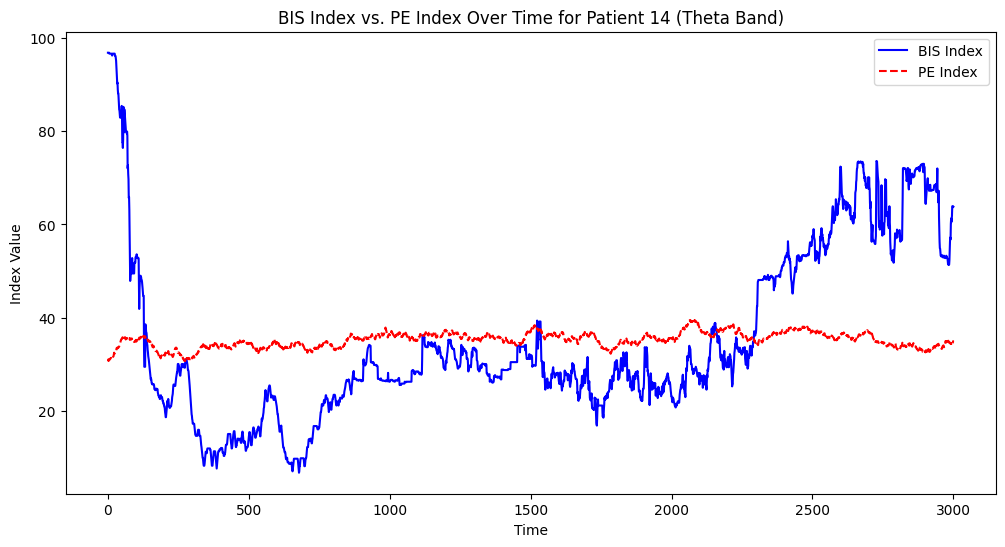

Combined Model RMSE:  18.33125612336195


In [24]:
# Create the PE index for theta band
pe_df_theta = pd.DataFrame(pe_values_theta, columns=['PE']) # Convert PE numpy array to pandas DataFrame
PE_theta = pe_df_theta.values.reshape(-1, 1)
PE_model_theta = LinearRegression()
PE_model_theta.fit(PE_theta, bis_series)
PE_index_theta = PE_model_theta.predict(PE_theta)

# Calculate the regression coefficients
k_PE_theta = PE_model_theta.coef_[0]
b_PE_theta = PE_model_theta.intercept_
print(f"PE Index Equation: BIS = {k_PE_theta} * PE1 + {b_PE_theta}")

# Plot BIS Index vs. PE Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(PE_index_theta, label='PE Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. PE Index Over Time for Patient 14 (Theta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the combined model
rmse_pe_theta = np.sqrt(mean_squared_error(bis_series, PE_index_theta))
print("Combined Model RMSE: ", rmse_pe_theta)


PE Index Equation: BIS = 949.0951445583526 * PE1 + -2413.222137494341


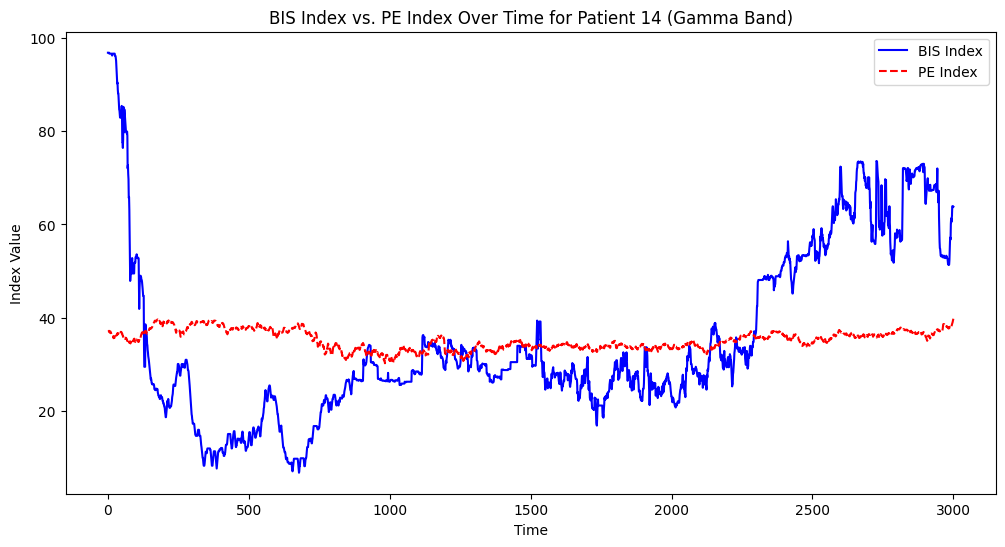

Combined Model RMSE:  18.286932683245688


In [25]:
# Create the PE index for gamma band
pe_df_gamma = pd.DataFrame(pe_values_gamma, columns=['PE']) # Convert PE numpy array to pandas DataFrame
PE_gamma = pe_df_gamma.values.reshape(-1, 1)
PE_model_gamma = LinearRegression()
PE_model_gamma.fit(PE_gamma, bis_series)
PE_index_gamma = PE_model_gamma.predict(PE_gamma)

# Calculate the regression coefficients
k_PE_gamma = PE_model_gamma.coef_[0]
b_PE_gamma = PE_model_gamma.intercept_
print(f"PE Index Equation: BIS = {k_PE_gamma} * PE1 + {b_PE_gamma}")

# Plot BIS Index vs. PE Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(PE_index_gamma, label='PE Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. PE Index Over Time for Patient 14 (Gamma Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the combined model
rmse_pe_gamma = np.sqrt(mean_squared_error(bis_series, PE_index_gamma))
print("Combined Model RMSE: ", rmse_pe_gamma)

PE Index Equation: BIS = 287.03632706217047 * PE1 + -603.4144970953876


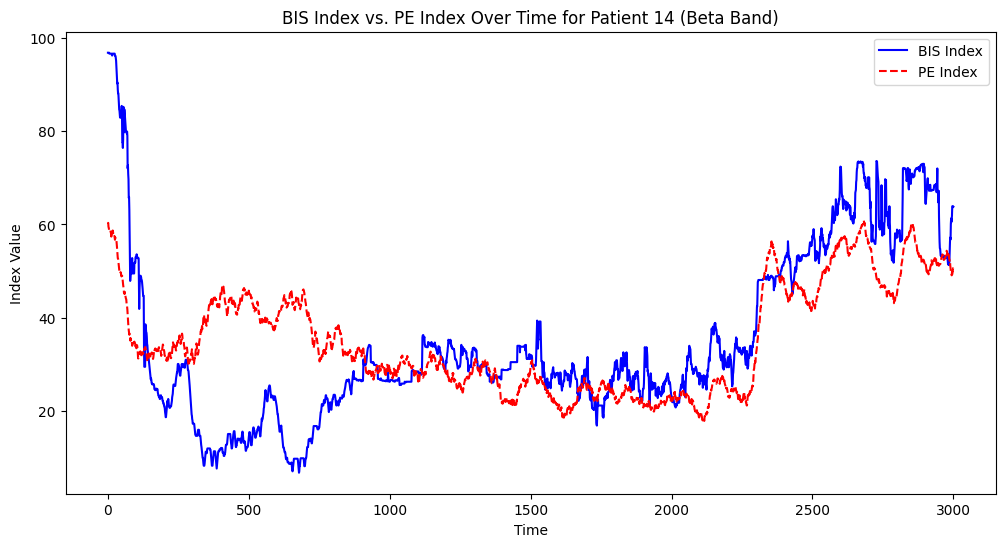

PE Beta Training Model RMSE:  14.45962587858445
PE Beta Training Model Pearson CC:  0.6184491485666379


In [26]:
pe_values_beta = []
for window in beta_windows:
    pe = ent.permutation_entropy(window, order=3, delay=1)
    pe_values_beta.append(pe)

pe_values_beta = np.array(pe_values_beta)

# Create the PE index for beta band
pe_df_beta = pd.DataFrame(pe_values_beta, columns=['PE']) # Convert PE numpy array to pandas DataFrame
PE_beta = pe_df_beta.values.reshape(-1, 1)
PE_model_beta = LinearRegression()
PE_model_beta.fit(PE_beta, bis_series)
PE_index_beta = PE_model_beta.predict(PE_beta)

# Calculate the regression coefficients
k_PE_beta = PE_model_beta.coef_[0]
b_PE_beta = PE_model_beta.intercept_
print(f"PE Index Equation: BIS = {k_PE_beta} * PE1 + {b_PE_beta}")

# Plot BIS Index vs. PE Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(PE_index_beta, label='PE Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. PE Index Over Time for Patient 14 (Beta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the combined model
rmse_pe_beta = np.sqrt(mean_squared_error(bis_series, PE_index_beta))
print("PE Beta Training Model RMSE: ", rmse_pe_beta)

# Calculate Pearson correlation coefficient
correlation_pe_alpha, _ = stats.pearsonr(bis_series, PE_index_beta)
print("PE Beta Training Model Pearson CC: ", correlation_pe_alpha)

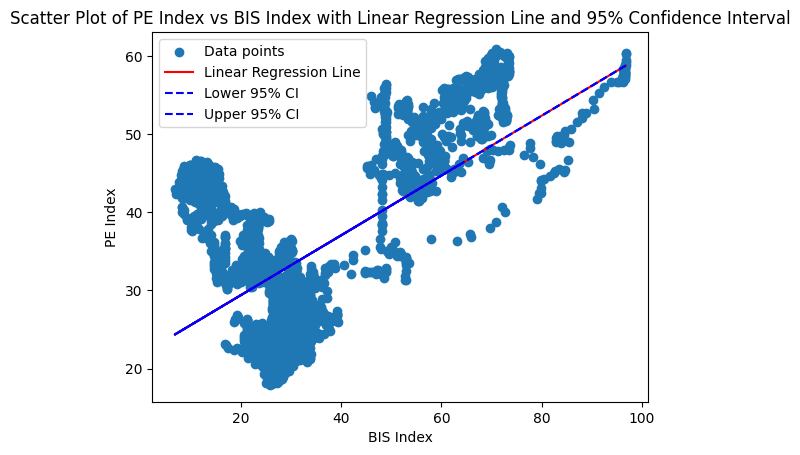

In [37]:
import scipy.stats as stats

# Scatter plot
plt.scatter(bis_series, PE_index_beta, label='Data points')

# Fit a linear regression model
slope, intercept, r_value, p_value, std_err = stats.linregress(bis_series, PE_index_beta)
line = slope * np.array(bis_series) + intercept

# Plot the regression line
plt.plot(bis_series, line, color='r', label='Linear Regression Line')

# 95% confidence interval for the regression line
#ci = 1.96 * std_err * np.sqrt(1/len(bis_series) + (np.array(bis_series) - np.mean(bis_series))**2 / np.sum((np.array(bis_series) - np.mean(bis_series))**2))
#plt.fill_between(bis_series, line - ci, line + ci, color='b', alpha=.1, label='95% Confidence Interval')

# 95% confidence interval for the regression line
ci = 1.96 * std_err * np.sqrt(1/len(bis_series) + (np.array(bis_series) - np.mean(bis_series))**2 / np.sum((np.array(bis_series) - np.mean(bis_series))**2))
plt.plot(bis_series, line - ci, 'b--', label='Lower 95% CI')
plt.plot(bis_series, line + ci, 'b--', label='Upper 95% CI')

plt.xlabel('BIS Index')
plt.ylabel('PE Index')
plt.title('Scatter Plot of PE Index vs BIS Index with Linear Regression Line and 95% Confidence Interval')
plt.legend()
plt.show()


In [41]:
mean = np.mean(PE_index_beta)

# Calculate the standard error of the mean (SEM)
sem = np.std(PE_index_beta, ddof=1) / np.sqrt(len(PE_index_beta))

# Calculate the 95% confidence interval
ci = 1.96 * sem

print(f"Mean: {mean}")
print(f"95% Confidence Interval: {ci}")
print(f"{sem}")


Mean: 35.22149283572143
95% Confidence Interval: 0.4072215508896115
0.20776609739265892


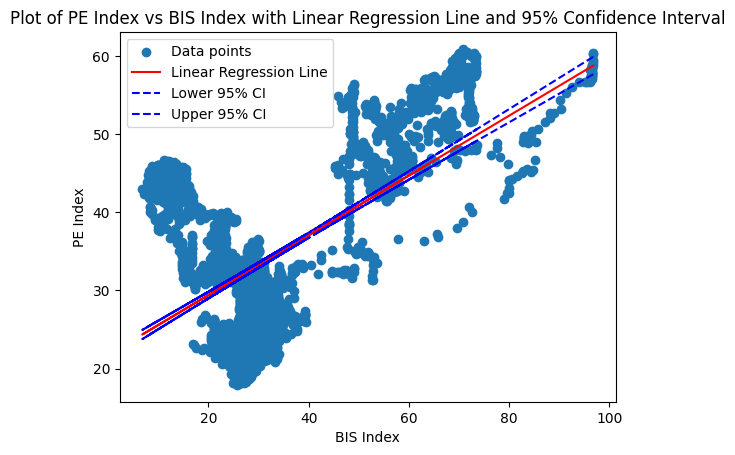

In [42]:
import statsmodels.api as sm

# Example: PE index and BIS index (replace with your actual data)
PE_index = PE_index_beta  # your PE index data
BIS_index = bis_series  # your BIS index data

# Add a constant for the intercept in the regression model
X = sm.add_constant(BIS_index)

# Fit the regression model
model = sm.OLS(PE_index, X).fit()

# Get the predictions from the model
predictions = model.get_prediction(X)

# Get the 95% confidence interval (CI) for the regression line
pred_int = predictions.conf_int()

# Plotting
plt.scatter(BIS_index, PE_index, label='Data points')
plt.plot(BIS_index, model.predict(X), color='red', label='Linear Regression Line')

# Plot the confidence interval (upper and lower bounds)
plt.plot(BIS_index, pred_int[:, 0], color='blue', linestyle='--', label='Lower 95% CI')
plt.plot(BIS_index, pred_int[:, 1], color='blue', linestyle='--', label='Upper 95% CI')

plt.xlabel('BIS Index')
plt.ylabel('PE Index')
plt.legend()
plt.title('Plot of PE Index vs BIS Index with Linear Regression Line and 95% Confidence Interval')
plt.show()


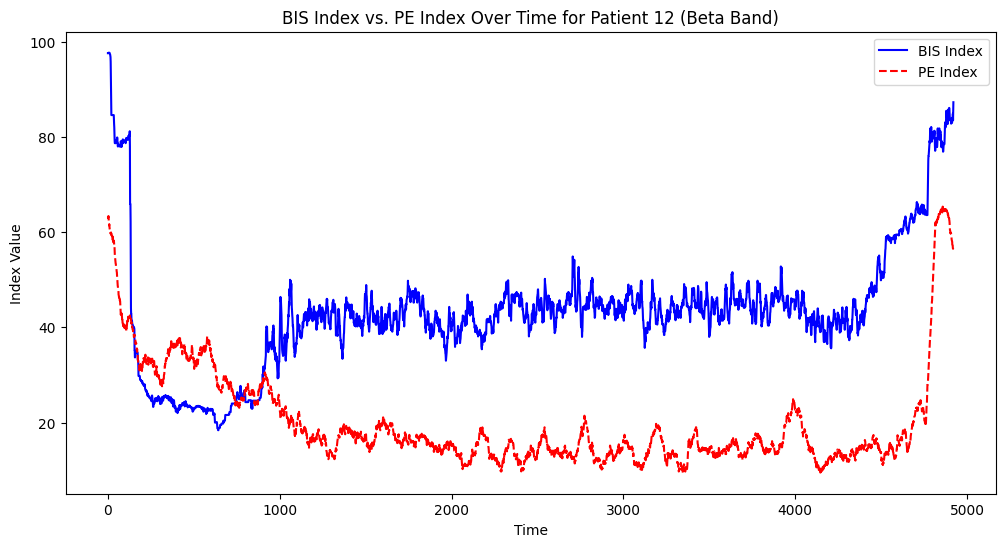

PE Beta Testing Model RMSE:  27.252006367354724
PE Beta Testing Model Pearson CC:  0.2770089606579181


In [28]:
# Calculate PE values for Patient 12
pe_values_beta_patient12 = []
for window in beta_windows_patient12:
    pe12 = ent.permutation_entropy(window, order=3, delay=1)
    pe_values_beta_patient12.append(pe12)

pe_values_beta_patient12 = np.array(pe_values_beta_patient12)

# Prepare trained model with test data
pe_df_beta_patient12 = pd.DataFrame(pe_values_beta_patient12, columns=['PE'])
X_pe_beta_patient12 = pe_df_beta_patient12[['PE']]

# Create the PE index
PE_beta_patient12 = X_pe_beta_patient12.values.reshape(-1, 1)
PE_index_beta_patient12 = PE_model_beta.predict(PE_beta_patient12)

# Plot BIS Index vs. PE Index
plt.figure(figsize=(12, 6))
plt.plot(bis_aligned_patient12, label='BIS Index', color='blue')
plt.plot(PE_index_beta_patient12, label='PE Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. PE Index Over Time for Patient 12 (Beta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the combined model
rmse_pe_beta_patient12 = np.sqrt(mean_squared_error(bis_aligned_patient12, PE_index_beta_patient12))
print("PE Beta Testing Model RMSE: ", rmse_pe_beta_patient12)

# Calculate Pearson correlation coefficient
correlation_pe_beta_patient12, _ = stats.pearsonr(bis_aligned_patient12, PE_index_beta_patient12)
print("PE Beta Testing Model Pearson CC: ", correlation_pe_beta_patient12)



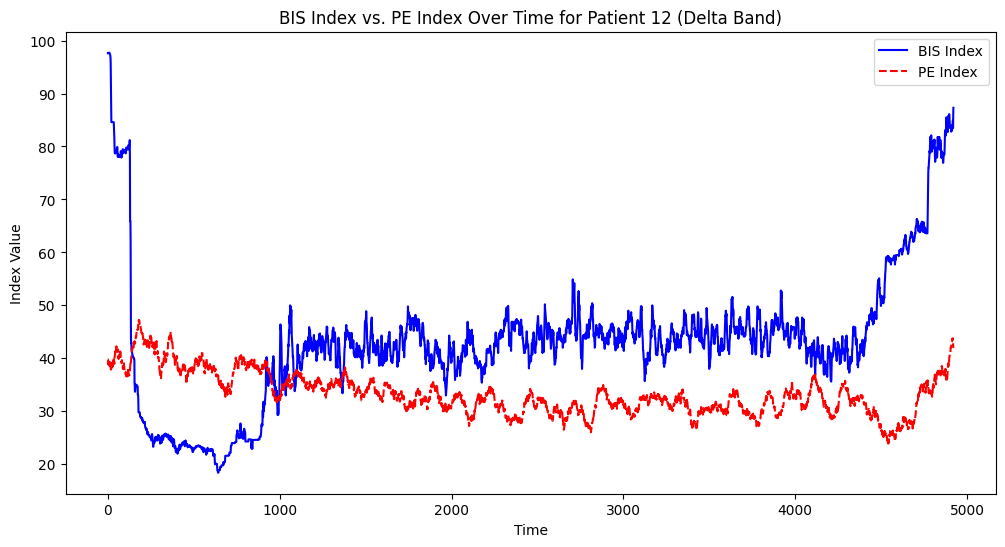

PE Delta Testing Model RMSE:  17.561317249439366
PE Delta Testing Model Pearson CC:  -0.23960550518781093


In [30]:
# Calculate PE values for Patient 12
pe_values_delta_patient12 = []
for window in delta_windows_patient12:
    pe12 = ent.permutation_entropy(window, order=3, delay=1)
    pe_values_delta_patient12.append(pe12)

pe_values_delta_patient12 = np.array(pe_values_delta_patient12)

# Prepare trained model with test data
pe_df_delta_patient12 = pd.DataFrame(pe_values_delta_patient12, columns=['PE'])
X_pe_delta_patient12 = pe_df_delta_patient12[['PE']]

# Create the PE index
PE_delta_patient12 = X_pe_delta_patient12.values.reshape(-1, 1)
PE_index_delta_patient12 = PE_model_delta.predict(PE_delta_patient12)

# Plot BIS Index vs. PE Index
plt.figure(figsize=(12, 6))
plt.plot(bis_aligned_patient12, label='BIS Index', color='blue')
plt.plot(PE_index_delta_patient12, label='PE Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. PE Index Over Time for Patient 12 (Delta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the combined model
rmse_pe_delta_patient12 = np.sqrt(mean_squared_error(bis_aligned_patient12, PE_index_delta_patient12))
print("PE Delta Testing Model RMSE: ", rmse_pe_delta_patient12)

# Calculate Pearson correlation coefficient
correlation_pe_delta_patient12, _ = stats.pearsonr(bis_aligned_patient12, PE_index_delta_patient12)
print("PE Delta Testing Model Pearson CC: ", correlation_pe_delta_patient12)



In [ ]:
plt.scatter(bis_series, PE_index_beta, color='blue', label='data')

Combined Index Equation: BIS = 12.76 * M1 + 1.51 * PE + 35.22


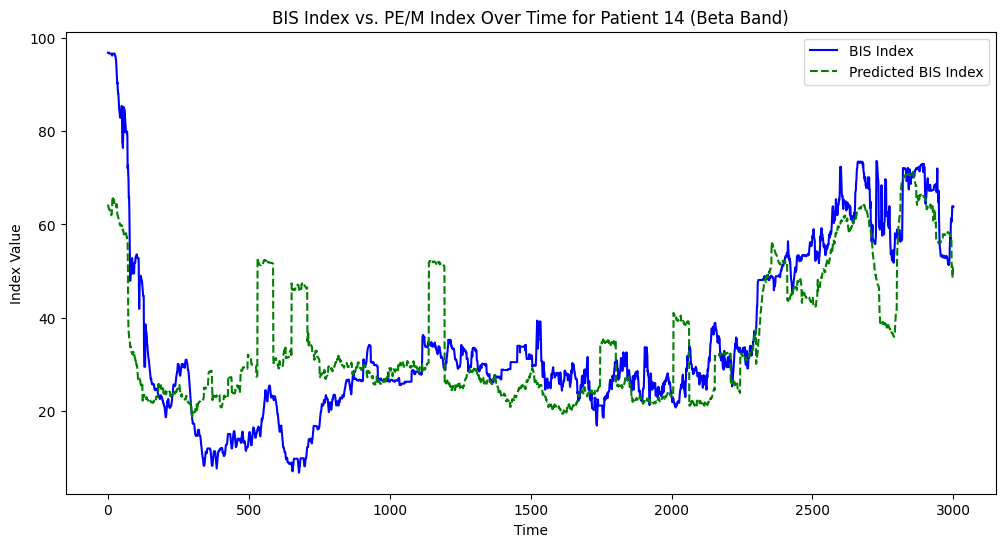

PE/M Beta Training Model RMSE:  11.990845305770769
PE/M Beta Training Model Pearson CC:  0.7585145252939626


In [112]:
from sklearn.preprocessing import StandardScaler

# Calculate mobility of given dataset
def calculate_mobility(signal):
    first_derivative = np.diff(signal, 1)
    variance = np.var(signal)
    variance_first_derivative = np.var(first_derivative)
    mobility = np.sqrt(variance_first_derivative / variance)
    return mobility

# Calculate mobility for each second
mobility_values_beta = []
for window in beta_windows:
    m = calculate_mobility(window)
    mobility_values_beta.append(m)

mobility_values_beta = np.array(mobility_values_beta)

# Normalise mobility and PE
features = np.column_stack((mobility_values_beta, pe_values_beta))
scaler = StandardScaler()
normalised_features = scaler.fit_transform(features)

M_index_norm_beta = normalised_features[:, 0]
PE_index_norm_beta = normalised_features[:, 1]

X_combined_beta = np.column_stack((M_index_norm_beta, PE_index_norm_beta))
y_combined_beta = bis_series 

# Initialize and fit the linear regression model
combined_model_beta = LinearRegression()
combined_model_beta.fit(X_combined_beta, y_combined_beta)

# Predict the BIS index using the learned model
combined_bis_beta = combined_model_beta.predict(X_combined_beta)

# Get the regression coefficients and intercept
coefficients = combined_model_beta.coef_
intercept = combined_model_beta.intercept_

# Output the combined index equation
print(f"Combined Index Equation: BIS = {coefficients[0]:.2f} * M1 + {coefficients[1]:.2f} * PE + {intercept:.2f}")

# Plot BIS Index vs. Predicted Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(combined_bis_beta, label='Predicted BIS Index', color='green', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. PE/M Index Over Time for Patient 14 (Beta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the combined model
rmse_combined_beta = np.sqrt(mean_squared_error(bis_series, combined_bis_beta))
print("PE/M Beta Training Model RMSE: ", rmse_combined_beta)

# Calculate Pearson correlation coefficient
correlation_combined_beta, _ = stats.pearsonr(combined_bis_beta, bis_series)
print("PE/M Beta Training Model Pearson CC: ", correlation_combined_beta)

Combined Index Equation: BIS = -0.75 * M1 + -2.62 * PE + 35.22


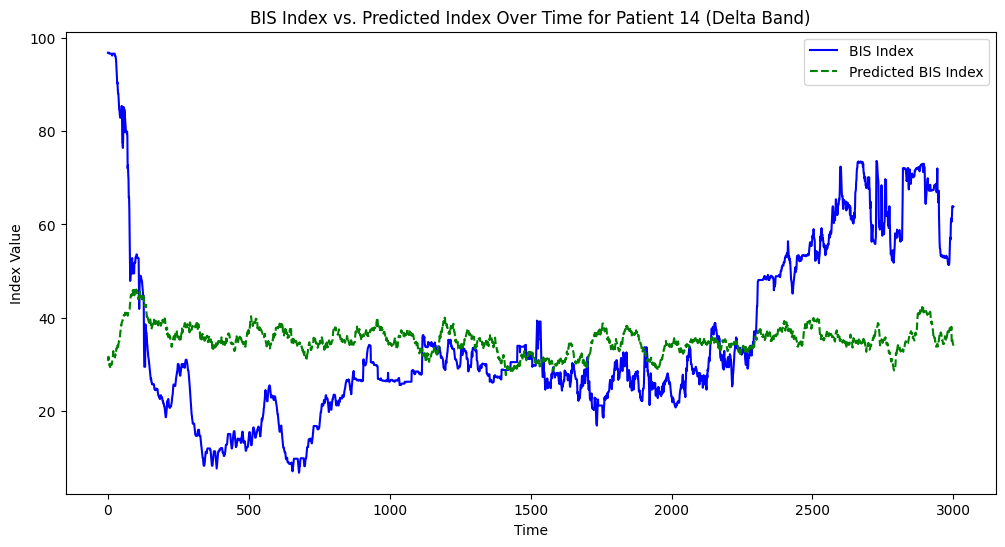

PE/M Delta Training Model RMSE:  18.171487386223824
PE/M Delta Training Model Pearson CC:  0.15730442812551845


In [113]:
# Calculate mobility for each second
mobility_values_delta = []
for window in delta_windows:
    m = calculate_mobility(window)
    mobility_values_delta.append(m)

mobility_values_delta = np.array(mobility_values_delta)

# Normalise mobility and PE
features = np.column_stack((mobility_values_delta, pe_values_delta))
scaler = StandardScaler()
normalised_features = scaler.fit_transform(features)

M_index_norm_delta = normalised_features[:, 0]
PE_index_norm_delta = normalised_features[:, 1]

X_combined_delta = np.column_stack((M_index_norm_delta, PE_index_norm_delta))
y_combined_delta = bis_series 

# Initialize and fit the linear regression model
combined_model_delta = LinearRegression()
combined_model_delta.fit(X_combined_delta, y_combined_delta)

# Predict the BIS index using the learned model
combined_bis_delta = combined_model_delta.predict(X_combined_delta)

# Get the regression coefficients and intercept
coefficients = combined_model_delta.coef_
intercept = combined_model_delta.intercept_

# Output the combined index equation
print(f"Combined Index Equation: BIS = {coefficients[0]:.2f} * M1 + {coefficients[1]:.2f} * PE + {intercept:.2f}")

# Plot BIS Index vs. Predicted Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(combined_bis_delta, label='Predicted BIS Index', color='green', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. Predicted Index Over Time for Patient 14 (Delta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the combined model
rmse_combined_delta = np.sqrt(mean_squared_error(bis_series, combined_bis_delta))
print("PE/M Delta Training Model RMSE: ", rmse_combined_delta)

# Calculate Pearson correlation coefficient
correlation_combined_delta, _ = stats.pearsonr(combined_bis_delta, bis_series)
print("PE/M Delta Training Model Pearson CC: ", correlation_combined_delta)


Combined Index Equation: BIS = -0.75 * M1 + -2.62 * PE + 35.22


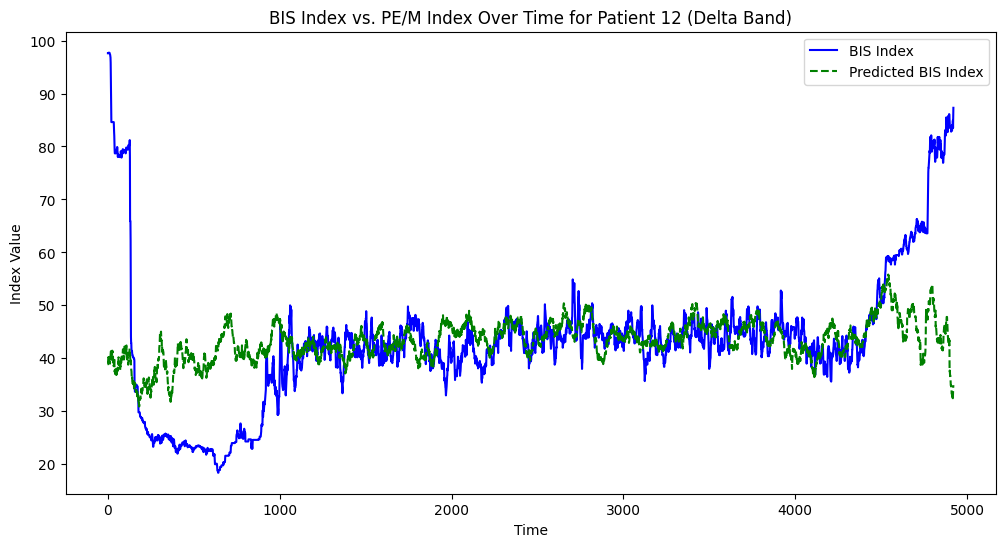

PE/M Delta Testing Model RMSE:  12.419039650578076
PE/M Delta Testing Model Pearson CC:  0.28106019072324895


In [114]:
# Calculate mobility for each second
mobility_values_delta_patient12 = []
for window in delta_windows_patient12:
    m = calculate_mobility(window)
    mobility_values_delta_patient12.append(m)

mobility_values_delta_patient12 = np.array(mobility_values_delta_patient12)

# Normalise mobility and PE
features_delta_patient12 = np.column_stack((mobility_values_delta_patient12, pe_values_delta_patient12))
scaler = StandardScaler()
normalised_features_delta_patient12 = scaler.fit_transform(features_delta_patient12)

M_index_norm_delta_patient12 = normalised_features_delta_patient12[:, 0]
PE_index_norm_delta_patient12 = normalised_features_delta_patient12[:, 1]

X_combined_delta_patient12 = np.column_stack((M_index_norm_delta_patient12, PE_index_norm_delta_patient12))
y_combined_delta_patient12 = bis_aligned_patient12 

combined_model_delta.fit(X_combined_delta_patient12, y_combined_delta_patient12)

# Predict the BIS index using the learned model
combined_bis_delta_patient12 = combined_model_delta.predict(X_combined_delta_patient12)

# Output the combined index equation
print(f"Combined Index Equation: BIS = {coefficients[0]:.2f} * M1 + {coefficients[1]:.2f} * PE + {intercept:.2f}")

# Plot BIS Index vs. Predicted Index
plt.figure(figsize=(12, 6))
plt.plot(bis_aligned_patient12, label='BIS Index', color='blue')
plt.plot(combined_bis_delta_patient12, label='Predicted BIS Index', color='green', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. PE/M Index Over Time for Patient 12 (Delta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the combined model
rmse_combined_delta_patient12 = np.sqrt(mean_squared_error(combined_bis_delta_patient12, bis_aligned_patient12))
print("PE/M Delta Testing Model RMSE: ", rmse_combined_delta_patient12)

# Calculate Pearson correlation coefficient
correlation_combined_delta_patient12, _ = stats.pearsonr(combined_bis_delta_patient12, bis_aligned_patient12)
print("PE/M Delta Testing Model Pearson CC: ", correlation_combined_delta_patient12)


In [ ]:
fd_values_delta = []

for i, window in enumerate(delta_windows):
    fd = ant.higuchi_fd(window)
    fd_values_delta.append(fd)

fd_values_delta = np.array(fd_values_delta)
print(fd_values_delta.shape)

# Create the FD index
fd_df_delta = pd.DataFrame(fd_values_delta, columns=['FD']) # Convert FD numpy array to pandas DataFrame
FD_delta = fd_df_delta.values.reshape(-1, 1)
FD_model_delta = LinearRegression()
FD_model_delta.fit(FD_delta, bis_series)
FD_index_delta = FD_model_delta.predict(FD_delta)

# Calculate the regression coefficients
k_FD_delta = FD_model_delta.coef_[0]
b_FD_delta = FD_model_delta.intercept_
print(f"FD Index Equation: BIS = {k_FD_delta} * FE1 + {b_FD_delta}")

# Plot BIS Index vs. FD Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(FD_index_delta, label='FD Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. FD Index Over Time for Patient 14 (Delta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the model
rmse_fd_delta = np.sqrt(mean_squared_error(FD_index_delta, bis_series))
print("FD Delta Training Model RMSE: ", rmse_fd_delta)

# Calculate Pearson correlation coefficient
correlation_fd_delta, _ = stats.pearsonr(FD_index_delta, bis_series)
print("FD Delta Training Model Pearson CC: ", correlation_fd_delta)

(3001,)
SPE Index Equation: BIS = 46.32167523818388 * FE1 + -384.12964722091664


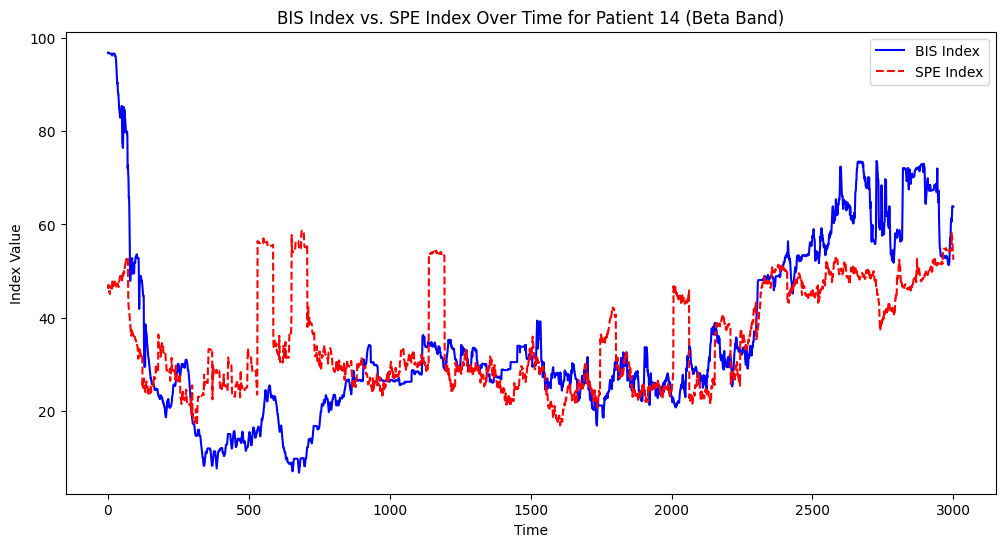

SPE Beta Training Model RMSE:  14.881479806038351
SPE Beta Training Model Pearson CC:  0.5881512519004074


In [104]:
spe_values_beta = []

for i, window in enumerate(beta_windows):
    spe = ant.spectral_entropy(window, sf=128)
    spe_values_beta.append(spe)

spe_values_beta = np.array(spe_values_beta)
print(spe_values_beta.shape)

# Create the SPE index
spe_df_beta = pd.DataFrame(spe_values_beta, columns=['SPE']) # Convert SPE numpy array to pandas DataFrame
SPE_beta = spe_df_beta.values.reshape(-1, 1)
SPE_model_beta = LinearRegression()
SPE_model_beta.fit(SPE_beta, bis_series)
SPE_index_beta = SPE_model_beta.predict(SPE_beta)

# Calculate the regression coefficients
k_SPE_beta = SPE_model_beta.coef_[0]
b_SPE_beta = SPE_model_beta.intercept_
print(f"SPE Index Equation: BIS = {k_SPE_beta} * FE1 + {b_SPE_beta}")

# Plot BIS Index vs. SPE Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(SPE_index_beta, label='SPE Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. SPE Index Over Time for Patient 14 (Beta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the model
rmse_spe_beta = np.sqrt(mean_squared_error(SPE_index_beta, bis_series))
print("SPE Beta Training Model RMSE: ", rmse_spe_beta)

# Calculate Pearson correlation coefficient
correlation_spe_beta, _ = stats.pearsonr(SPE_index_beta, bis_series)
print("SPE Beta Training Model Pearson CC: ", correlation_spe_beta)

(3001,)
SPE Index Equation: BIS = -24.24392322798996 * FE1 + 208.98100052606821


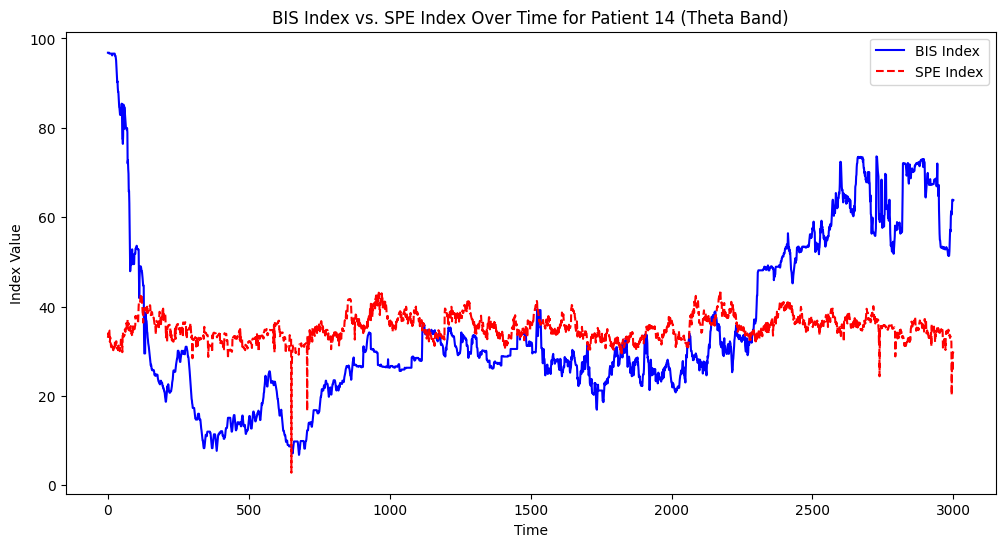

SPE Theta Training Model RMSE:  18.191800448121523
SPE Theta Training Model Pearson CC:  0.150210116746173


In [105]:
spe_values_theta = []

for i, window in enumerate(theta_windows):
    spe = ant.spectral_entropy(window, sf=128)
    spe_values_theta.append(spe)

spe_values_theta = np.array(spe_values_theta)
print(spe_values_theta.shape)

# Create the SPE index
spe_df_theta = pd.DataFrame(spe_values_theta, columns=['SPE']) # Convert SPE numpy array to pandas DataFrame
SPE_theta = spe_df_theta.values.reshape(-1, 1)
SPE_model_theta = LinearRegression()
SPE_model_theta.fit(SPE_theta, bis_series)
SPE_index_theta = SPE_model_theta.predict(SPE_theta)

# Calculate the regression coefficients
k_SPE_theta = SPE_model_theta.coef_[0]
b_SPE_theta = SPE_model_theta.intercept_
print(f"SPE Index Equation: BIS = {k_SPE_theta} * FE1 + {b_SPE_theta}")

# Plot BIS Index vs. SPE Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(SPE_index_theta, label='SPE Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. SPE Index Over Time for Patient 14 (Theta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the model
rmse_spe_theta = np.sqrt(mean_squared_error(SPE_index_theta, bis_series))
print("SPE Theta Training Model RMSE: ", rmse_spe_theta)

# Calculate Pearson correlation coefficient
correlation_spe_theta, _ = stats.pearsonr(SPE_index_theta, bis_series)
print("SPE Theta Training Model Pearson CC: ", correlation_spe_theta)


(4921,)
SPE Index Equation: BIS = -24.24392322798996 * SPE1 + 208.98100052606821


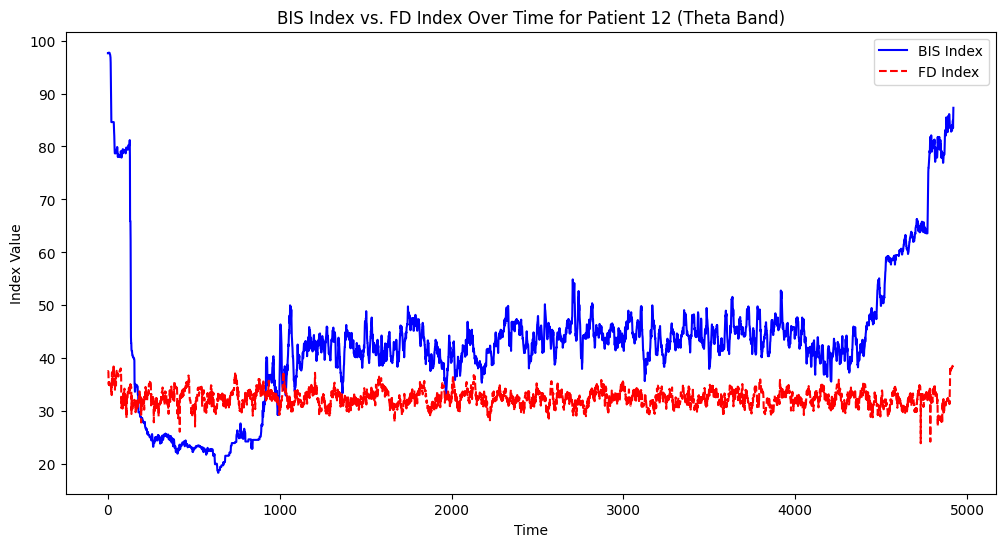

SPE Theta Testing Model RMSE:  16.852973605827334
SPE Theta Testing Model Pearson CC:  0.05820024292968616


In [106]:
spe_values_theta_patient12 = []

for i, window in enumerate(theta_windows_patient12):
    spe2 = ant.spectral_entropy(window, sf=128)
    spe_values_theta_patient12.append(spe2)

spe_values_theta_patient12 = np.array(spe_values_theta_patient12)
print(spe_values_theta_patient12.shape)

# Create the SPE index for testing (Theta Band)
spe_df_theta_patient12 = pd.DataFrame(spe_values_theta_patient12, columns=['SPE2']) # Convert SE numpy array to pandas DataFrame
SPE_theta_patient12 = spe_df_theta_patient12.values.reshape(-1, 1)
SPE_index_theta_patient12 = SPE_model_theta.predict(SPE_theta_patient12)

# Print regression equation
print(f"SPE Index Equation: BIS = {k_SPE_theta} * SPE1 + {b_SPE_theta}")

# Plot BIS Index vs. SPE Index
plt.figure(figsize=(12, 6))
plt.plot(bis_aligned_patient12, label='BIS Index', color='blue')
plt.plot(SPE_index_theta_patient12, label='FD Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. SPE Index Over Time for Patient 12 (Theta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE)
rmse_SPE_theta_patient12 = np.sqrt(mean_squared_error(SPE_index_theta_patient12, bis_aligned_patient12))
print("SPE Theta Testing Model RMSE: ", rmse_SPE_theta_patient12)

# Calculate Pearson correlation coefficient
correlation_spe_theta_patient12, _ = stats.pearsonr(SPE_index_theta_patient12, bis_aligned_patient12)
print("SPE Theta Testing Model Pearson CC: ", correlation_spe_theta_patient12)

SE Index Equation: BIS = 26.971894230090832 * FE1 + -7.818537969594232


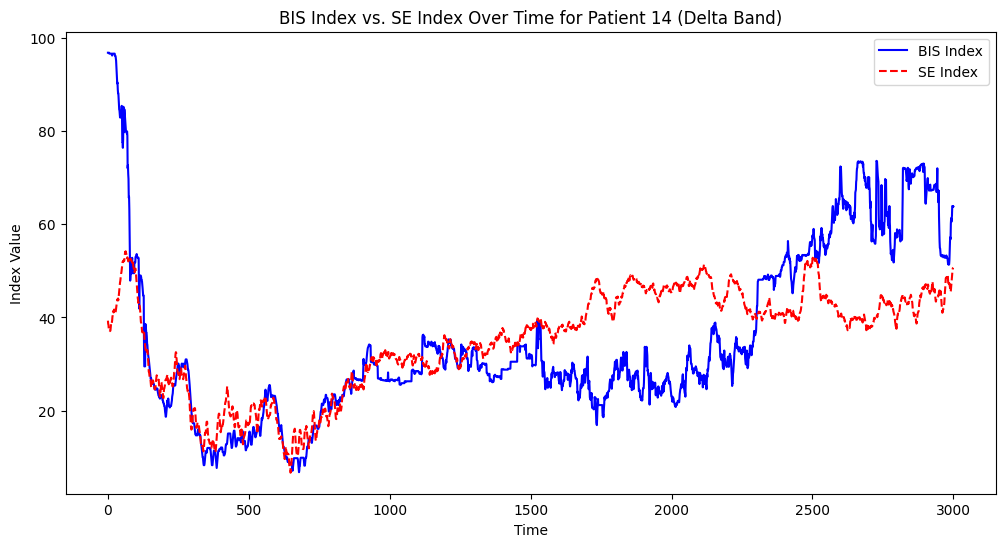

SE Delta Training Model RMSE:  14.844347437348043
SE Delta Training Model Pearson CC:  0.5909161894670545


In [88]:
# Load sample entropy values of delta band
se_values_delta = np.load('se_values_delta.npy')

# Create the SE index
se_df_delta = pd.DataFrame(se_values_delta, columns=['SE']) # Convert SE numpy array to pandas DataFrame
SE_delta = se_df_delta.values.reshape(-1, 1)
SE_model_delta = LinearRegression()
SE_model_delta.fit(SE_delta, bis_series)
SE_index_delta = SE_model_delta.predict(SE_delta)

# Calculate the regression coefficients
k_SE_delta = SE_model_delta.coef_[0]
b_SE_delta = SE_model_delta.intercept_
print(f"SE Index Equation: BIS = {k_SE_delta} * FE1 + {b_SE_delta}")

# Plot BIS Index vs. SE Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(SE_index_delta, label='SE Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. SE Index Over Time for Patient 14 (Delta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the model
rmse_se_delta = np.sqrt(mean_squared_error(SE_index_delta, bis_series))
print("SE Delta Training Model RMSE: ", rmse_se_delta)

# Calculate Pearson correlation coefficient
correlation_se_delta, _ = stats.pearsonr(SE_index_delta, bis_series)
print("SE Delta Training Model Pearson CC: ", correlation_se_delta)


SE Index Equation: BIS = 26.971894230090832 * FE1 + -7.818537969594232


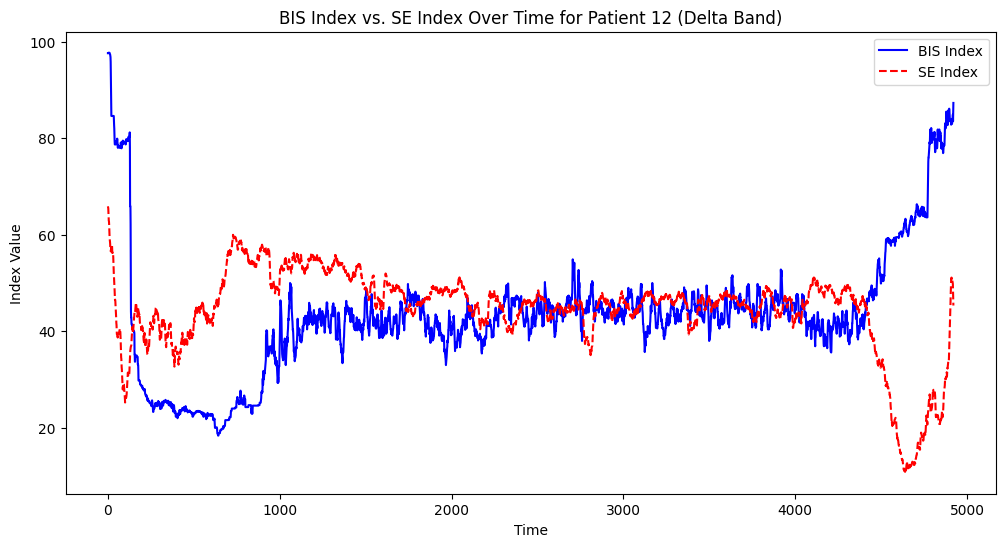

SE Delta Testing Model RMSE:  18.791040426619382
SE Delta Testing Model Pearson CC:  -0.4740310505337182


In [89]:
# Load sample entropy values of delta band for Patient 12
se_values_delta_patient12 = np.load('se_values_delta_patient12.npy')

# Create the SE index
se_df_delta_patient12 = pd.DataFrame(se_values_delta_patient12, columns=['SE']) # Convert SE numpy array to pandas DataFrame
SE_delta_patient12 = se_df_delta_patient12.values.reshape(-1, 1)
SE_index_delta_patient12 = SE_model_delta.predict(SE_delta_patient12)

# Calculate the regression coefficients
print(f"SE Index Equation: BIS = {k_SE_delta} * FE1 + {b_SE_delta}")

# Plot BIS Index vs. SE Index
plt.figure(figsize=(12, 6))
plt.plot(bis_aligned_patient12, label='BIS Index', color='blue')
plt.plot(SE_index_delta_patient12, label='SE Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. SE Index Over Time for Patient 12 (Delta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the model
rmse_se_delta_patient12 = np.sqrt(mean_squared_error(SE_index_delta_patient12, bis_aligned_patient12))
print("SE Delta Testing Model RMSE: ", rmse_se_delta_patient12)

# Calculate Pearson correlation coefficient
correlation_se_delta_patient12, _ = stats.pearsonr(SE_index_delta_patient12, bis_aligned_patient12)
print("SE Delta Testing Model Pearson CC: ", correlation_se_delta_patient12)

In [ ]:
# Create new index based on 3 features: mobility, PE, and SE, and train it on Patient 14

# Normalise mobility, PE, and SE
features3 = np.column_stack((mobility_values_delta, pe_values_delta, se_values_delta))
scaler = StandardScaler()
normalised_features3 = scaler.fit_transform(features3)

M_index_norm3 = normalised_features3[:, 0]
PE_index_norm3 = normalised_features3[:, 1]
SE_index_norm3 = normalised_features3[:, 2]

X_combined3 = np.column_stack((M_index_norm3, PE_index_norm3, SE_index_norm3))
y_combined3 = bis_series 

# Initialize and fit the linear regression model
combined_model3 = LinearRegression()
combined_model3.fit(X_combined3, y_combined3)

# Predict the BIS index using the learned model
predicted_bis3 = combined_model3.predict(X_combined3)

# Get the regression coefficients and intercept
coefficients3 = combined_model3.coef_
intercept3 = combined_model3.intercept_

# Output the combined index equation
print(f"Combined Index (3 features) Equation: BIS = {coefficients3[0]:.2f} * M1 + {coefficients3[1]:.2f} * PE + {coefficients3[2]:.2f} * SE + {intercept3:.2f}")

# Plot BIS Index vs. Predicted Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(predicted_bis3, label='Predicted BIS Index', color='green', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. Predicted 3-Feature Index Over Time for Patient 14 (Delta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the combined model
rmse_combined3 = np.sqrt(mean_squared_error(bis_series, predicted_bis3))
print("Combined Model (3 features) Delta Training Model RMSE: ", rmse_combined3)

# Calculate Pearson correlation coefficient
correlation_combined3_delta, _ = stats.pearsonr(predicted_bis3, bis_series)
print("Combined Model (3 features) Delta Training Model Pearson CC: ", correlation_combined3_delta)

In [ ]:
# Calculate mobility for each second
mobility_values_delta_patient12 = []
for window in delta_windows_patient12:
    m = calculate_mobility(window)
    mobility_values_delta_patient12.append(m)

mobility_values_delta_patient12 = np.array(mobility_values_delta_patient12)

# Create new index based on 3 features: mobility, PE, and SE, and test it on Patient 12

# Normalise mobility, PE, and SE
features3_patient12 = np.column_stack((mobility_values_delta_patient12, pe_values_delta_patient12, se_values_delta_patient12))
scaler = StandardScaler()
normalised_features3_patient12 = scaler.fit_transform(features3_patient12)

M_index_norm3_patient12 = normalised_features3_patient12[:, 0]
PE_index_norm3_patient12 = normalised_features3_patient12[:, 1]
SE_index_norm3_patient12 = normalised_features3_patient12[:, 2]

X_combined3_patient12 = np.column_stack((M_index_norm3_patient12, PE_index_norm3_patient12, SE_index_norm3_patient12))
y_combined3_patient12 = bis_series 

# Predict the BIS index using the learned model
predicted_bis3_patient12 = combined_model3.predict(X_combined3_patient12)

# Output the combined index equation
print(f"Combined Index (3 features) Equation: BIS = {coefficients3[0]:.2f} * M1 + {coefficients3[1]:.2f} * PE + {coefficients3[2]:.2f} * SE + {intercept3:.2f}")

# Plot BIS Index vs. Predicted Index
plt.figure(figsize=(12, 6))
plt.plot(bis_aligned_patient12, label='BIS Index', color='blue')
plt.plot(predicted_bis3_patient12, label='Predicted BIS Index', color='green', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. Predicted 3-Feature Index Over Time for Patient 12 (Delta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the combined model
rmse_combined3_patient12 = np.sqrt(mean_squared_error(bis_aligned_patient12, predicted_bis3_patient12))
print("Combined Model (3 features) Delta Testing Model RMSE: ", rmse_combined3_patient12)

# Calculate Pearson correlation coefficient
correlation_combined3_delta_patient12, _ = stats.pearsonr(predicted_bis3_patient12, bis_aligned_patient12)
print("Combined Model (3 features) Delta Testing Model Pearson CC: ", correlation_combined3_delta_patient12)


In [ ]:
# Get mean and standard error
mean_beta = np.mean(PE_index_beta)
se_beta = stats.sem(PE_index_beta)

# Calculate 95% confidence interval
confidence = 0.95
ci_beta = stats.t.interval(confidence, len(PE_index_beta)-1, loc=mean, scale=se)

# Calculate CI distance
ci_distance_beta = ci_beta[1] - ci_beta[0]

# Print CI
print("Mean:", mean_beta)
print("CI:", ci_beta)
print("CI Distance:", ci_distance_beta)

SE Index Equation: BIS = 44.35637871352023 * FE1 + -19.45528840469965


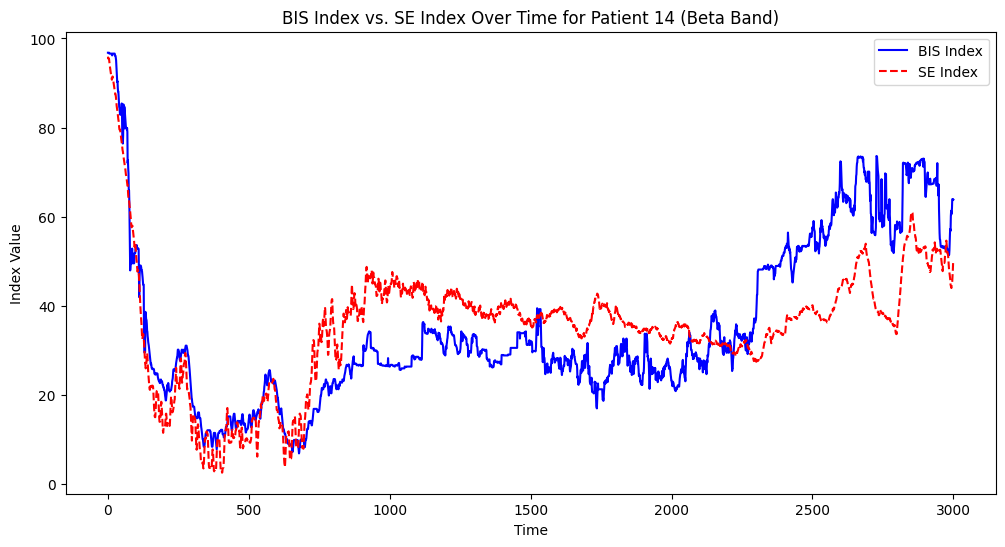

SE Beta Training Model RMSE:  11.936246307788968
SE Beta Training Model Pearson CC:  0.761053695159619


In [98]:
# Load sample entropy values of beta band
se_values_beta = np.load('se_values2.npy')

# Create the SE index
se_df_beta = pd.DataFrame(se_values_beta, columns=['SE']) # Convert SE numpy array to pandas DataFrame
SE_beta = se_df_beta.values.reshape(-1, 1)
SE_model_beta = LinearRegression()
SE_model_beta.fit(SE_beta, bis_series)
SE_index_beta = SE_model_beta.predict(SE_beta)

# Calculate the regression coefficients
k_SE_beta = SE_model_beta.coef_[0]
b_SE_beta = SE_model_beta.intercept_
print(f"SE Index Equation: BIS = {k_SE_beta} * FE1 + {b_SE_beta}")

# Plot BIS Index vs. SE Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(SE_index_beta, label='SE Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. SE Index Over Time for Patient 14 (Beta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the model
rmse_se_beta = np.sqrt(mean_squared_error(SE_index_beta, bis_series))
print("SE Beta Training Model RMSE: ", rmse_se_beta)

# Calculate Pearson correlation coefficient
correlation_se_beta, _ = stats.pearsonr(SE_index_beta, bis_series)
print("SE Beta Training Model Pearson CC: ", correlation_se_beta)


SE Index Equation: BIS = 44.35637871352023 * FE1 + -19.45528840469965


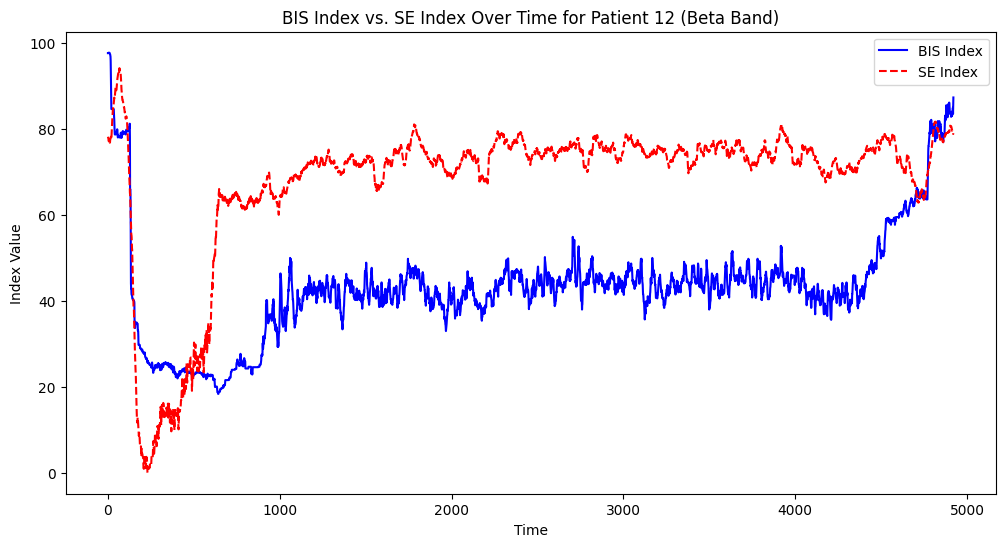

SE Beta Testing Model RMSE:  28.336523195024633
SE Beta Testing Model Pearson CC:  0.5698623143548859


In [99]:
# Load sample entropy values of beta band for Patient 12
se_values_beta_patient12 = np.load('se_values_patient12.npy')

# Create the SE index
se_df_beta_patient12 = pd.DataFrame(se_values_beta_patient12, columns=['SE']) # Convert SE numpy array to pandas DataFrame
SE_beta_patient12 = se_df_beta_patient12.values.reshape(-1, 1)
SE_index_beta_patient12 = SE_model_beta.predict(SE_beta_patient12)

# Calculate the regression coefficients
print(f"SE Index Equation: BIS = {k_SE_beta} * FE1 + {b_SE_beta}")

# Plot BIS Index vs. SE Index
plt.figure(figsize=(12, 6))
plt.plot(bis_aligned_patient12, label='BIS Index', color='blue')
plt.plot(SE_index_beta_patient12, label='SE Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. SE Index Over Time for Patient 12 (Beta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the model
rmse_se_beta_patient12 = np.sqrt(mean_squared_error(SE_index_beta_patient12, bis_aligned_patient12))
print("SE Beta Testing Model RMSE: ", rmse_se_beta_patient12)

# Calculate Pearson correlation coefficient
correlation_se_beta_patient12, _ = stats.pearsonr(SE_index_beta_patient12, bis_aligned_patient12)
print("SE Beta Testing Model Pearson CC: ", correlation_se_beta_patient12)


FD Index Equation: BIS = 959.4142652100251 * FE1 + -1855.1058617249985


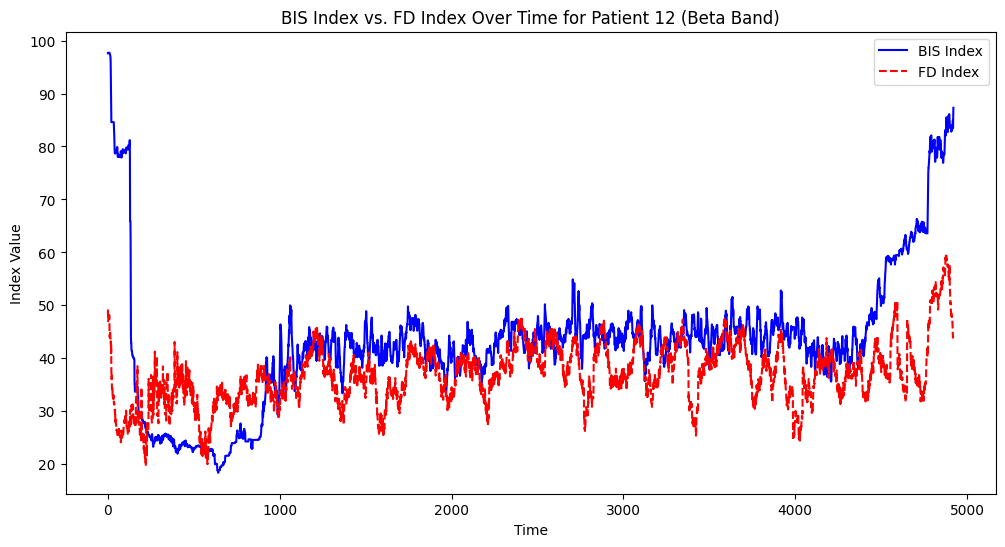

FD Beta Testing Model RMSE:  13.316161177260915
FD Beta Testing Model Pearson CC:  0.4330638241203164


In [125]:
fd_values_beta_patient12 = []

for i, window in enumerate(beta_windows_patient12):
    fd2 = ant.higuchi_fd(window)
    fd_values_beta_patient12.append(fd2)

fd_values_beta_patient12 = np.array(fd_values_beta_patient12)

# Create the FD index for Patient 12
fd_df_beta_patient12 = pd.DataFrame(fd_values_beta_patient12, columns=['FD']) # Convert FD numpy array to pandas DataFrame
FD_beta_patient12 = fd_df_beta_patient12.values.reshape(-1, 1)
FD_index_beta_patient12 = FD_model_beta.predict(FD_beta_patient12)

# Calculate the regression coefficients
print(f"FD Index Equation: BIS = {k_FD_beta} * FE1 + {b_FD_beta}")

# Plot BIS Index vs. FD Index
plt.figure(figsize=(12, 6))
plt.plot(bis_aligned_patient12, label='BIS Index', color='blue')
plt.plot(FD_index_beta_patient12, label='FD Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. FD Index Over Time for Patient 12 (Beta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the model
rmse_fd_beta_patient12 = np.sqrt(mean_squared_error(FD_index_beta_patient12, bis_aligned_patient12))
print("FD Beta Testing Model RMSE: ", rmse_fd_beta_patient12)

# Calculate Pearson correlation coefficient
correlation_fd_beta_patient12, _ = stats.pearsonr(FD_index_beta_patient12, bis_aligned_patient12)
print("FD Beta Testing Model Pearson CC: ", correlation_fd_beta_patient12)

SPE Index Equation: BIS = 46.32167523818388 * FE1 + -384.12964722091664


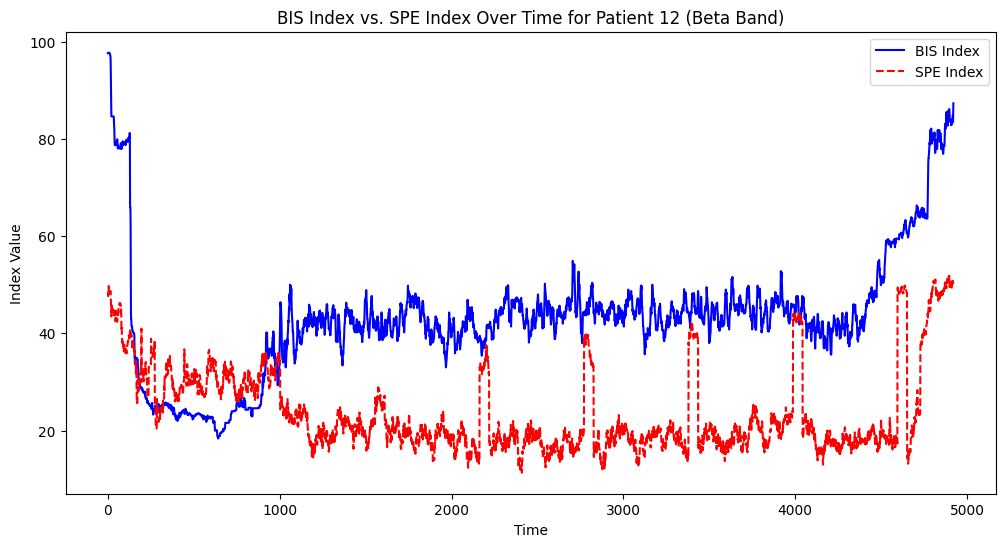

SPE Beta Testing Model RMSE:  23.61010583536935
SPE Beta Testing Model Pearson CC:  0.2968672885157952


In [127]:
spe_values_beta_patient12 = []

for i, window in enumerate(beta_windows_patient12):
    spe2 = ant.spectral_entropy (window, sf=128)
    spe_values_beta_patient12.append(spe2)

spe_values_beta_patient12 = np.array(spe_values_beta_patient12)

# Create the SPE index for Patient 12
spe_df_beta_patient12 = pd.DataFrame(spe_values_beta_patient12, columns=['SPE']) # Convert SPE numpy array to pandas DataFrame
SPE_beta_patient12 = spe_df_beta_patient12.values.reshape(-1, 1)
SPE_index_beta_patient12 = SPE_model_beta.predict(SPE_beta_patient12)

# Calculate the regression coefficients
print(f"SPE Index Equation: BIS = {k_SPE_beta} * FE1 + {b_SPE_beta}")

# Plot BIS Index vs. SPE Index
plt.figure(figsize=(12, 6))
plt.plot(bis_aligned_patient12, label='BIS Index', color='blue')
plt.plot(SPE_index_beta_patient12, label='SPE Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. SPE Index Over Time for Patient 12 (Beta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the model
rmse_spe_beta_patient12 = np.sqrt(mean_squared_error(SPE_index_beta_patient12, bis_aligned_patient12))
print("SPE Beta Testing Model RMSE: ", rmse_spe_beta_patient12)

# Calculate Pearson correlation coefficient
correlation_spe_beta_patient12, _ = stats.pearsonr(SPE_index_beta_patient12, bis_aligned_patient12)
print("SPE Beta Testing Model Pearson CC: ", correlation_spe_beta_patient12)

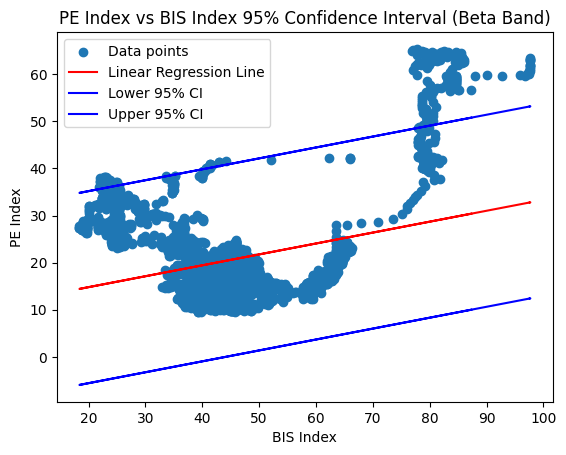

20.38224842747116


In [84]:
import statsmodels.api as sm

# PE index and BIS index 
PE_index = PE_index_beta_patient12
BIS_index = bis_aligned_patient12 

# Add constant for intercept in regression model
X = sm.add_constant(BIS_index)

# Fit the regression model
pe_beta_ci_model = sm.OLS(PE_index, X).fit()

pe_beta_stderr = np.std(pe_beta_ci_model.resid)
pe_beta_ci_distance = 1.96 * pe_beta_stderr

# Plotting
plt.scatter(BIS_index, PE_index, label='Data points')
plt.plot(BIS_index, pe_beta_ci_model.predict(X), color='red', label='Linear Regression Line')

# Plot the confidence interval (upper and lower bounds)
plt.plot(BIS_index, pe_beta_ci_model.predict(X) + pe_beta_ci_distance, color='blue', label='Lower 95% CI')
plt.plot(BIS_index, pe_beta_ci_model.predict(X) - pe_beta_ci_distance, color='blue', label='Upper 95% CI')

plt.xlabel('BIS Index')
plt.ylabel('PE Index')
plt.legend()
plt.title('PE Index vs BIS Index 95% Confidence Interval (Beta Band)')
plt.show()

print(f"{pe_beta_ci_distance}")

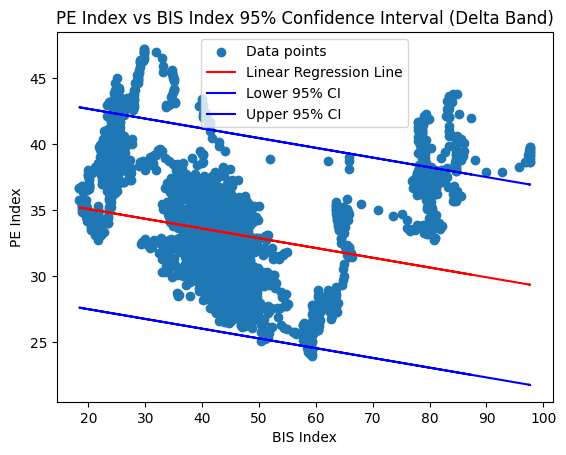

7.5906612147817265


In [85]:
# PE index and BIS index 
PE_index = PE_index_delta_patient12
BIS_index = bis_aligned_patient12 

# Add constant for intercept in regression model
X = sm.add_constant(BIS_index)

# Fit the regression model
pe_delta_ci_model = sm.OLS(PE_index, X).fit()

pe_delta_stderr = np.std(pe_delta_ci_model.resid)
pe_delta_ci_distance = 1.96 * pe_delta_stderr

# Plotting
plt.scatter(BIS_index, PE_index, label='Data points')
plt.plot(BIS_index, pe_delta_ci_model.predict(X), color='red', label='Linear Regression Line')

# Plot the confidence interval (upper and lower bounds)
plt.plot(BIS_index, pe_delta_ci_model.predict(X) + pe_delta_ci_distance, color='blue', label='Lower 95% CI')
plt.plot(BIS_index, pe_delta_ci_model.predict(X) - pe_delta_ci_distance, color='blue', label='Upper 95% CI')

plt.xlabel('BIS Index')
plt.ylabel('PE Index')
plt.legend()
plt.title('PE Index vs BIS Index 95% Confidence Interval (Delta Band)')
plt.show()

print(f"{pe_delta_ci_distance}")

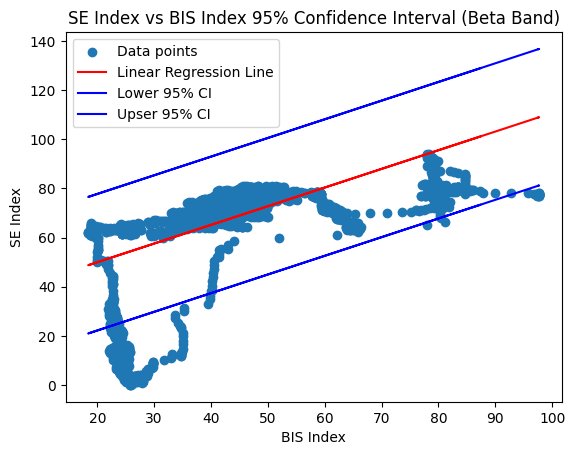

27.760866945146482


In [100]:
# SE index and BIS index 
SE_index = SE_index_beta_patient12
BIS_index = bis_aligned_patient12 

# Add constant for intercept in regression model
X = sm.add_constant(BIS_index)

# Fit the regression model
se_beta_ci_model = sm.OLS(SE_index, X).fit()

se_beta_stderr = np.std(se_beta_ci_model.resid)
se_beta_ci_distance = 1.96 * se_beta_stderr

# Plotting
plt.scatter(BIS_index, SE_index, label='Data points')
plt.plot(BIS_index, se_beta_ci_model.predict(X), color='red', label='Linear Regression Line')

# Plot the confidence interval (upser and lower bounds)
plt.plot(BIS_index, se_beta_ci_model.predict(X) + se_beta_ci_distance, color='blue', label='Lower 95% CI')
plt.plot(BIS_index, se_beta_ci_model.predict(X) - se_beta_ci_distance, color='blue', label='Upser 95% CI')

plt.xlabel('BIS Index')
plt.ylabel('SE Index')
plt.legend()
plt.title('SE Index vs BIS Index 95% Confidence Interval (Beta Band)')
plt.show()

print(f"{se_beta_ci_distance}")

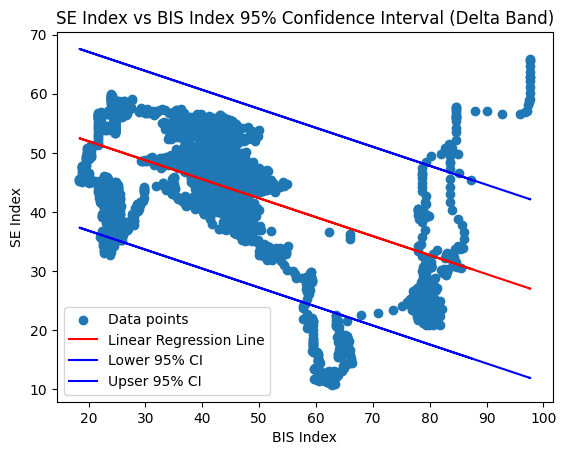

15.131174866439851


In [90]:
# SE index and BIS index 
SE_index = SE_index_delta_patient12
BIS_index = bis_aligned_patient12 

# Add constant for intercept in regression model
X = sm.add_constant(BIS_index)

# Fit the regression model
se_delta_ci_model = sm.OLS(SE_index, X).fit()

se_delta_stderr = np.std(se_delta_ci_model.resid)
se_delta_ci_distance = 1.96 * se_delta_stderr

# Plotting
plt.scatter(BIS_index, SE_index, label='Data points')
plt.plot(BIS_index, se_delta_ci_model.predict(X), color='red', label='Linear Regression Line')

# Plot the confidence interval (upser and lower bounds)
plt.plot(BIS_index, se_delta_ci_model.predict(X) + se_delta_ci_distance, color='blue', label='Lower 95% CI')
plt.plot(BIS_index, se_delta_ci_model.predict(X) - se_delta_ci_distance, color='blue', label='Upser 95% CI')

plt.xlabel('BIS Index')
plt.ylabel('SE Index')
plt.legend()
plt.title('SE Index vs BIS Index 95% Confidence Interval (Delta Band)')
plt.show()

print(f"{se_delta_ci_distance}")

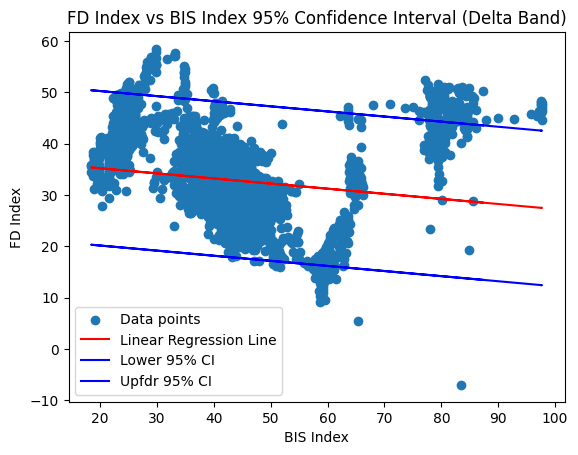

15.055565908691154


In [102]:
# FD index and BIS index 
FD_index = FD_index_delta_patient12
BIS_index = bis_aligned_patient12 

# Add constant for intercept in regression model
X = sm.add_constant(BIS_index)

# Fit the regression model
fd_delta_ci_model = sm.OLS(FD_index, X).fit()

fd_delta_stderr = np.std(fd_delta_ci_model.resid)
fd_delta_ci_distance = 1.96 * fd_delta_stderr

# Plotting
plt.scatter(BIS_index, FD_index, label='Data points')
plt.plot(BIS_index, fd_delta_ci_model.predict(X), color='red', label='Linear Regression Line')

# Plot the confidence interval (upfdr and lower bounds)
plt.plot(BIS_index, fd_delta_ci_model.predict(X) + fd_delta_ci_distance, color='blue', label='Lower 95% CI')
plt.plot(BIS_index, fd_delta_ci_model.predict(X) - fd_delta_ci_distance, color='blue', label='Upfdr 95% CI')

plt.xlabel('BIS Index')
plt.ylabel('FD Index')
plt.legend()
plt.title('FD Index vs BIS Index 95% Confidence Interval (Delta Band)')
plt.show()

print(f"{fd_delta_ci_distance}")

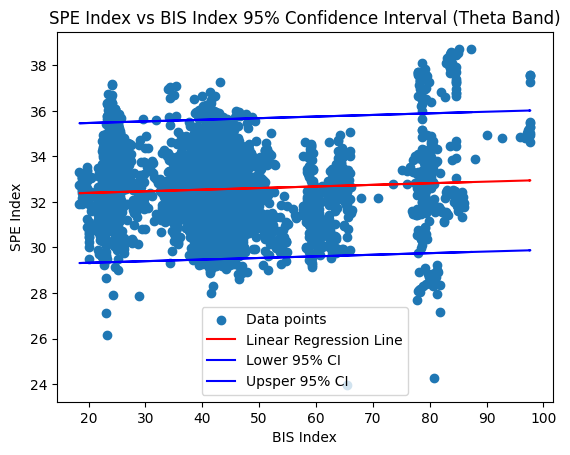

3.0698571855505787


In [107]:
# SPE index and BIS index 
SPE_index = SPE_index_theta_patient12
BIS_index = bis_aligned_patient12 

# Add constant for intercept in regression model
X = sm.add_constant(BIS_index)

# Fit the regression model
spe_theta_ci_model = sm.OLS(SPE_index, X).fit()

spe_theta_stderr = np.std(spe_theta_ci_model.resid)
spe_theta_ci_distance = 1.96 * spe_theta_stderr

# Plotting
plt.scatter(BIS_index, SPE_index, label='Data points')
plt.plot(BIS_index, spe_theta_ci_model.predict(X), color='red', label='Linear Regression Line')

# Plot the confidence interval (upsper and lower bounds)
plt.plot(BIS_index, spe_theta_ci_model.predict(X) + spe_theta_ci_distance, color='blue', label='Lower 95% CI')
plt.plot(BIS_index, spe_theta_ci_model.predict(X) - spe_theta_ci_distance, color='blue', label='Upsper 95% CI')

plt.xlabel('BIS Index')
plt.ylabel('SPE Index')
plt.legend()
plt.title('SPE Index vs BIS Index 95% Confidence Interval (Theta Band)')
plt.show()

print(f"{spe_theta_ci_distance}")


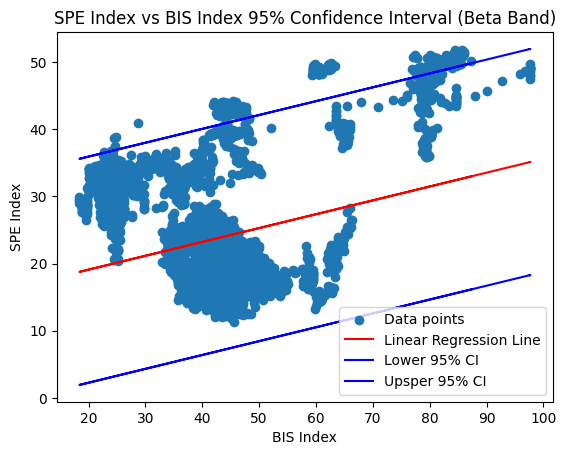

16.831551266193017


In [128]:
# SPE index and BIS index 
SPE_index = SPE_index_beta_patient12
BIS_index = bis_aligned_patient12 

# Add constant for intercept in regression model
X = sm.add_constant(BIS_index)

# Fit the regression model
spe_beta_ci_model = sm.OLS(SPE_index, X).fit()

spe_beta_stderr = np.std(spe_beta_ci_model.resid)
spe_beta_ci_distance = 1.96 * spe_beta_stderr

# Plotting
plt.scatter(BIS_index, SPE_index, label='Data points')
plt.plot(BIS_index, spe_beta_ci_model.predict(X), color='red', label='Linear Regression Line')

# Plot the confidence interval (upsper and lower bounds)
plt.plot(BIS_index, spe_beta_ci_model.predict(X) + spe_beta_ci_distance, color='blue', label='Lower 95% CI')
plt.plot(BIS_index, spe_beta_ci_model.predict(X) - spe_beta_ci_distance, color='blue', label='Upsper 95% CI')

plt.xlabel('BIS Index')
plt.ylabel('SPE Index')
plt.legend()
plt.title('SPE Index vs BIS Index 95% Confidence Interval (Beta Band)')
plt.show()

print(f"{spe_beta_ci_distance}")


Mobility Index Equation: BIS = 207.0764915487591 * M1 + -149.97075746583008


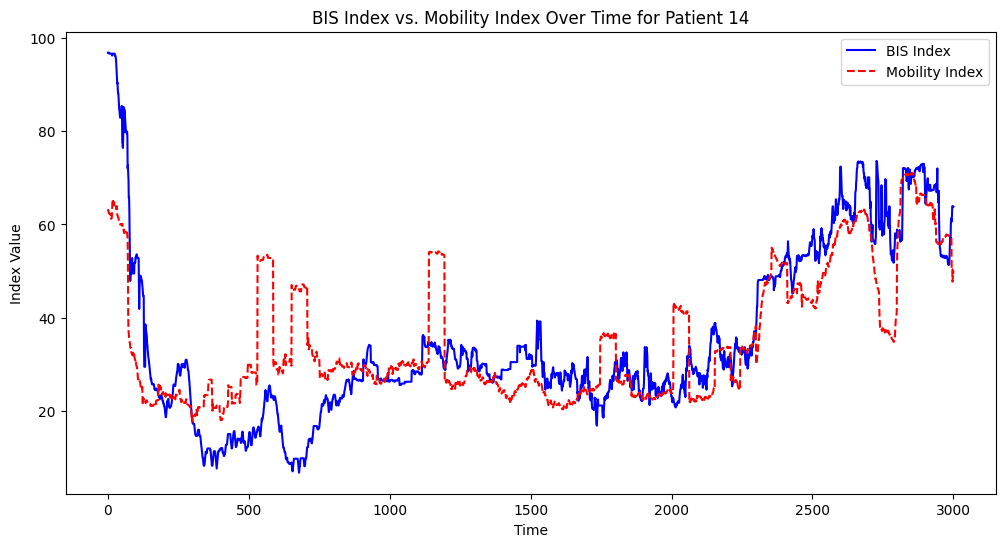

Mobility Beta Training Model RMSE:  12.028974557200312
Mobility Beta Training Model Pearson CC:  0.7567293417983827


In [120]:
# Calculate mobility for Patient 14
mobility_beta_values = []
for window in beta_windows:
    m = calculate_mobility(window)
    mobility_beta_values.append(m)

mobility_beta_values = np.array(mobility_beta_values)

# Create the Mobility index
M_df_beta = pd.DataFrame(mobility_beta_values, columns=['M']) # Convert SE numpy array to pandas DataFrame 
M_beta = M_df_beta.values.reshape(-1, 1)
M_model_beta = LinearRegression()
M_model_beta.fit(M_beta, bis_series)
M_index_beta = M_model_beta.predict(M_beta)

# Calculate the regression coefficients
k_M_beta = M_model_beta.coef_[0]
b_M_beta = M_model_beta.intercept_
print(f"Mobility Index Equation: BIS = {k_M_beta} * M1 + {b_M_beta}")

# Plot BIS Index vs. Mobility Index
plt.figure(figsize=(12, 6))
plt.plot(bis_series, label='BIS Index', color='blue')
plt.plot(M_index_beta, label='Mobility Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. Mobility Index Over Time for Patient 14 (Beta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the model
rmse_m_beta = np.sqrt(mean_squared_error(M_index_beta, bis_series))
print("Mobility Beta Training Model RMSE: ", rmse_m_beta)

# Calculate Pearson correlation coefficient
correlation_m_beta, _ = stats.pearsonr(M_index_beta, bis_series)
print("Mobility Beta Training Model Pearson CC: ", correlation_m_beta)

Mobility Index Equation: BIS = 207.0764915487591 * M1 + -149.97075746583008


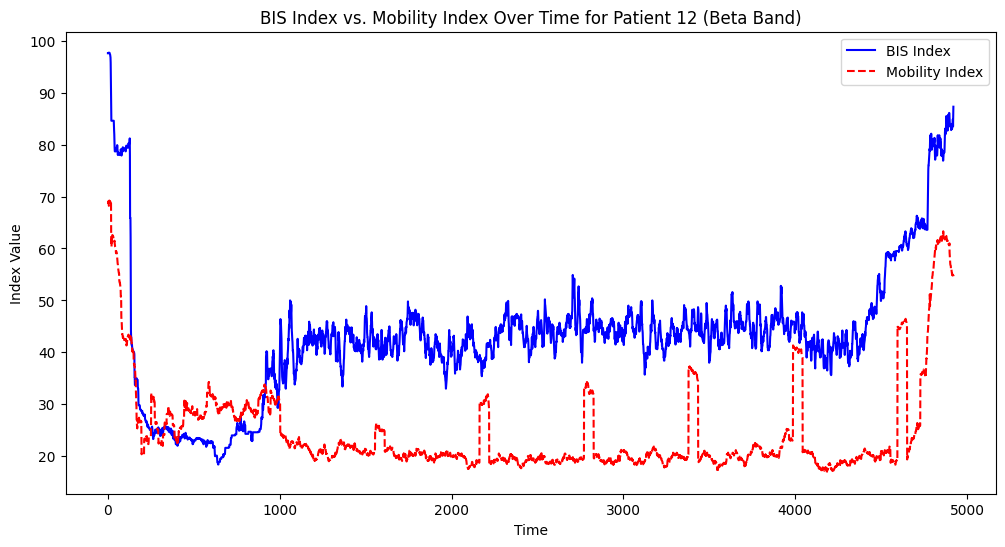

Mobility Beta Testing Model RMSE:  21.78367700575233
Mobility Beta Testing Model Pearson CC:  0.5162877377277852


In [122]:
# Calculate mobility for Patient 12
mobility_beta_values_patient12 = []
for window in beta_windows_patient12:
    m = calculate_mobility(window)
    mobility_beta_values_patient12.append(m)

mobility_beta_values_patient12 = np.array(mobility_beta_values_patient12)

# Create the Mobility index for Patient 12
M_df_beta_patient12 = pd.DataFrame(mobility_beta_values_patient12, columns=['M']) # Convert SE numpy array to pandas DataFrame 
M_beta_patient12 = M_df_beta_patient12.values.reshape(-1, 1)
M_index_beta_patient12 = M_model_beta.predict(M_beta_patient12)

# Calculate the regression coefficients
print(f"Mobility Index Equation: BIS = {k_M_beta} * M1 + {b_M_beta}")

# Plot BIS Index vs. Mobility Index
plt.figure(figsize=(12, 6))
plt.plot(bis_aligned_patient12, label='BIS Index', color='blue')
plt.plot(M_index_beta_patient12, label='Mobility Index', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Index Value')
plt.title('BIS Index vs. Mobility Index Over Time for Patient 12 (Beta Band)')
plt.legend()
plt.show()

# Calculate Root Mean Square Error (RMSE) for the model
rmse_m_beta_patient12 = np.sqrt(mean_squared_error(M_index_beta_patient12, bis_aligned_patient12))
print("Mobility Beta Testing Model RMSE: ", rmse_m_beta_patient12)

# Calculate Pearson correlation coefficient
correlation_m_beta_patient12, _ = stats.pearsonr(M_index_beta_patient12, bis_aligned_patient12)
print("Mobility Beta Testing Model Pearson CC: ", correlation_m_beta_patient12)

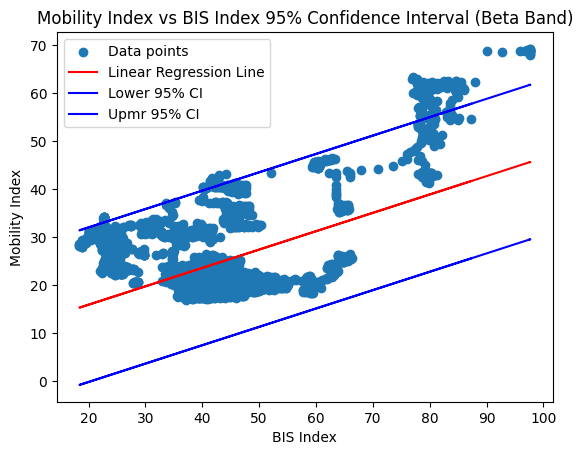

16.118536920575732


In [123]:
# M index and BIS index 
M_index = M_index_beta_patient12
BIS_index = bis_aligned_patient12 

# Add constant for intercept in regression model
X = sm.add_constant(BIS_index)

# Fit the regression model
m_beta_ci_model = sm.OLS(M_index, X).fit()

m_beta_stderr = np.std(m_beta_ci_model.resid)
m_beta_ci_distance = 1.96 * m_beta_stderr

# Plotting
plt.scatter(BIS_index, M_index, label='Data points')
plt.plot(BIS_index, m_beta_ci_model.predict(X), color='red', label='Linear Regression Line')

# Plot the confidence interval (upmr and lower bounds)
plt.plot(BIS_index, m_beta_ci_model.predict(X) + m_beta_ci_distance, color='blue', label='Lower 95% CI')
plt.plot(BIS_index, m_beta_ci_model.predict(X) - m_beta_ci_distance, color='blue', label='Upmr 95% CI')

plt.xlabel('BIS Index')
plt.ylabel('Mobility Index')
plt.legend()
plt.title('Mobility Index vs BIS Index 95% Confidence Interval (Beta Band)')
plt.show()

print(f"{m_beta_ci_distance}")


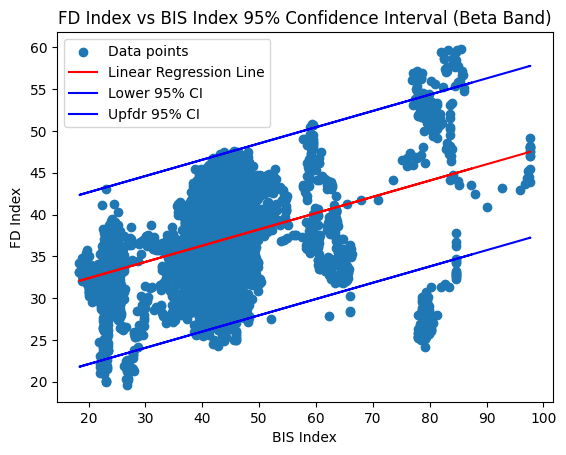

10.276235114406044


In [126]:
# FD index and BIS index 
FD_index = FD_index_beta_patient12
BIS_index = bis_aligned_patient12 

# Add constant for intercept in regression model
X = sm.add_constant(BIS_index)

# Fit the regression model
fd_beta_ci_model = sm.OLS(FD_index, X).fit()

fd_beta_stderr = np.std(fd_beta_ci_model.resid)
fd_beta_ci_distance = 1.96 * fd_beta_stderr

# Plotting
plt.scatter(BIS_index, FD_index, label='Data points')
plt.plot(BIS_index, fd_beta_ci_model.predict(X), color='red', label='Linear Regression Line')

# Plot the confidence interval (upfdr and lower bounds)
plt.plot(BIS_index, fd_beta_ci_model.predict(X) + fd_beta_ci_distance, color='blue', label='Lower 95% CI')
plt.plot(BIS_index, fd_beta_ci_model.predict(X) - fd_beta_ci_distance, color='blue', label='Upfdr 95% CI')

plt.xlabel('BIS Index')
plt.ylabel('FD Index')
plt.legend()
plt.title('FD Index vs BIS Index 95% Confidence Interval (Beta Band)')
plt.show()

print(f"{fd_beta_ci_distance}")
